In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


In [2]:
import numpy as np
import pandas as pd
import json
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
sns.set_theme(font="Arial", palette="deep")
sns.set(font="Arial")
%matplotlib inline
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# **Load and Explore Data**
---

In [3]:
# Load both train and test datasets
train_df = pd.read_csv("/kaggle/input/playground-series-s4e11/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv")

# List of dataframes
dfs = [("train", train_df), ("test", test_df)]
for name, df in dfs:
    print(f"The {name} contains {df.shape[0]} rows and {df.shape[1]} columns.")
    display(df.sample(n=8, random_state=42))
    print()

The train contains 140700 rows and 20 columns.


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
18347,18347,Sanya,Female,51.0,Patna,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,More than 8 hours,Moderate,B.Ed,No,11.0,2.0,Yes,0
96193,96193,Sneha,Female,20.0,Agra,Working Professional,NaN,NaN,1.0,NaN,NaN,4.0,Less than 5 hours,Moderate,Class 12,No,0.0,5.0,Yes,0
100005,100005,Aanchal,Female,21.0,Ahmedabad,Student,NaN,2.0,NaN,7.82,5.0,NaN,5-6 hours,Healthy,MA,Yes,12.0,2.0,Yes,0
39890,39890,Rahil,Male,36.0,Indore,Working Professional,Teacher,NaN,5.0,NaN,NaN,2.0,Less than 5 hours,Moderate,MBBS,No,1.0,1.0,No,0
98243,98243,Rishi,Male,60.0,Mumbai,Working Professional,HR Manager,NaN,2.0,NaN,NaN,2.0,5-6 hours,Moderate,BBA,No,6.0,2.0,No,0
88194,88194,Dhruv,Male,25.0,Varanasi,Working Professional,Teacher,NaN,1.0,NaN,NaN,5.0,Less than 5 hours,Moderate,B.Arch,No,1.0,2.0,No,0
102244,102244,Ritik,Male,56.0,Varanasi,Working Professional,Data Scientist,NaN,4.0,NaN,NaN,4.0,More than 8 hours,Healthy,BCA,Yes,3.0,4.0,Yes,0
8022,8022,Abhinav,Male,48.0,Nagpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,4.0,More than 8 hours,Unhealthy,B.Com,No,1.0,1.0,No,0



The test contains 93800 rows and 19 columns.


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
48587,189287,Ritik,Male,45.0,Varanasi,Working Professional,Business Analyst,NaN,2.0,NaN,NaN,5.0,7-8 hours,Healthy,M.Com,No,3.0,2.0,No
79643,220343,Eshita,Female,44.0,Kanpur,Working Professional,Marketing Manager,NaN,3.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,2.0,5.0,No
90518,231218,Aariv,Male,50.0,Nagpur,Working Professional,Entrepreneur,NaN,5.0,NaN,NaN,5.0,5-6 hours,Moderate,BCA,No,2.0,1.0,Yes
88332,229032,Aishwarya,Female,52.0,Mumbai,Working Professional,Investment Banker,NaN,4.0,NaN,NaN,2.0,Less than 5 hours,Moderate,MBA,Yes,5.0,5.0,Yes
28928,169628,Zoya,Female,40.0,Srinagar,Working Professional,Plumber,NaN,3.0,NaN,NaN,4.0,7-8 hours,Unhealthy,BE,Yes,0.0,5.0,No
22048,162748,Tushar,Male,40.0,Surat,Working Professional,Teacher,NaN,4.0,NaN,NaN,4.0,5-6 hours,Unhealthy,MSc,No,12.0,5.0,No
16069,156769,Anaya,Female,59.0,Bangalore,Working Professional,Consultant,NaN,3.0,NaN,NaN,4.0,7-8 hours,Healthy,ME,No,5.0,5.0,Yes
67497,208197,Pooja,Female,25.0,Indore,Student,NaN,5.0,NaN,6.83,5.0,NaN,7-8 hours,Unhealthy,B.Arch,Yes,10.0,4.0,Yes


In [4]:
# Normalize all values
for name, df in dfs:
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].str.strip().str.lower()

In [5]:
# Define a function to generate combined statistics
def get_combined_stats(data):
    # View columns and datatypes
    cols_dtype = data.dtypes.rename("Datatype").reset_index()
    cols_dtype = cols_dtype.rename(columns={"index": "Column"})

    # View missing values
    missing_count = data.isnull().sum().rename("Missing Value Count").reset_index()
    missing_count["% Missing"] = (
        (missing_count["Missing Value Count"] / len(data)) * 100)
    missing_count = missing_count.rename(columns={"index": "Column"})

    # View zero values
    zero_count = data.eq(0).sum().reset_index()
    zero_count.columns = ["Column", "Zero Value Count"]
    zero_count["% Zero"] = (
        (zero_count["Zero Value Count"] / len(data)) * 100).round(2)
    zero_count = zero_count.rename(columns={"index": "Column"})

    # View min and max values for numerical columns
    num_cols = data.select_dtypes(include=["int", "float"]).columns
    if not num_cols.empty:
        min_max_values = data[num_cols].agg(["min", "max"]).T
        min_max_values = min_max_values.rename(
            columns={"min": "Min Value", "max": "Max Value"})
        min_max_values.index.name = "Column"
    else:
        min_max_values = pd.DataFrame(columns=["Min Value", "Max Value"])
        min_max_values.index.name = "Column"

    # View min and max values for categorical columns
    obj_cols = data.select_dtypes(include=["object", "category"]).columns
    category_info = data[obj_cols].apply(
        lambda col: [col.value_counts().idxmin(), col.value_counts().idxmax()]).T
    category_info.columns = ["Min Value", "Max Value"]
    category_info.index.name = "Column"

    # View min and max values for datetime columns
    date_cols = data.select_dtypes(include=["datetime64[ns]"]).columns
    if not date_cols.empty:
        min_max_dates = data[date_cols].agg(["min", "max"]).T
        min_max_dates = min_max_dates.rename(
            columns={"min": "Min Value", "max": "Max Value"})
        min_max_dates.index.name = "Column"
    else:
        min_max_dates = pd.DataFrame(columns=["Min Value", "Max Value"])
        min_max_dates.index.name = "Column"

    combined_info = pd.concat(
        [min_max_values, category_info, min_max_dates], axis=0)

    # View count of unique values
    unique_count = data.nunique().rename("Unique Value Count").reset_index()
    unique_count = unique_count.rename(columns={"index": "Column"})

    # View list of unique values
    unique_values_list = []
    for col in data.columns:
        if len(data[col].unique()) > 40:
            unique_values_list.append(
                {"Column": col, "Unique Values": "Many unique values"})
        else:
            unique_values_list.append(
                {"Column": col, "Unique Values": data[col].unique()})
    unique_values_data = pd.DataFrame(unique_values_list).set_index("Column")

    # Combine all statistics
    combined_stats = cols_dtype.merge(missing_count, on="Column").merge(zero_count, on="Column").merge(
        combined_info, on="Column", how="left").merge(unique_count, on="Column", how="right").merge(unique_values_data, on="Column", how="left")
    
    display(combined_stats)
    return combined_stats

In [6]:
# View info for each dataset
for name, df in dfs:
    print(f"{name}")
    get_combined_stats(df)
    print()

train


,Column,Datatype,Missing Value Count,% Missing,Zero Value Count,% Zero,Min Value,Max Value,Unique Value Count,Unique Values
0,id,int64,0,0.000000,1,0.00,0.0,140699.0,140700,Many unique values
1,Name,object,0,0.000000,0,0.00,rupika,rohan,422,Many unique values
2,Gender,object,0,0.000000,0,0.00,female,male,2,"[female, male]"
3,Age,float64,0,0.000000,0,0.00,18.0,60.0,43,Many unique values
4,City,object,0,0.000000,0,0.00,m.tech,kalyan,98,Many unique values
5,Working Professional or Student,object,0,0.000000,0,0.00,student,working professional,2,"[working professional, student]"
6,Profession,object,36630,26.034115,0,0.00,dev,teacher,64,Many unique values
7,Academic Pressure,float64,112803,80.172708,0,0.00,1.0,5.0,5,"[nan, 5.0, 2.0, 3.0, 4.0, 1.0]"
8,Work Pressure,float64,27918,19.842217,0,0.00,1.0,5.0,5,"[5.0, 4.0, nan, 1.0, 2.0, 3.0]"
9,CGPA,float64,112802,80.171997,0,0.00,5.03,10.0,331,Many unique values



test


,Column,Datatype,Missing Value Count,% Missing,Zero Value Count,% Zero,Min Value,Max Value,Unique Value Count,Unique Values
0,id,int64,0,0.000000,0,0.00,140700.0,234499.0,93800,Many unique values
1,Name,object,0,0.000000,0,0.00,vane,rohan,374,Many unique values
2,Gender,object,0,0.000000,0,0.00,female,male,2,"[male, female]"
3,Age,float64,0,0.000000,0,0.00,18.0,60.0,44,Many unique values
4,City,object,0,0.000000,0,0.00,san vasai-virar,kalyan,68,Many unique values
5,Working Professional or Student,object,0,0.000000,0,0.00,student,working professional,2,"[working professional, student]"
6,Profession,object,24632,26.260128,0,0.00,unveil,teacher,64,Many unique values
7,Academic Pressure,float64,75033,79.992537,0,0.00,1.0,5.0,5,"[nan, 5.0, 1.0, 3.0, 4.0, 2.0]"
8,Work Pressure,float64,18778,20.019190,0,0.00,1.0,5.0,5,"[2.0, 4.0, nan, 5.0, 1.0, 3.0]"
9,CGPA,float64,75034,79.993603,0,0.00,5.03,10.0,326,Many unique values


In [7]:
# Rename long column names
column_mapping = {
    'Working Professional or Student': 'Status',
    'Academic Pressure': 'Acad_Pressure',
    'Work Pressure': 'Work_Pressure',
    'Study Satisfaction': 'Study_Sat',
    'Job Satisfaction': 'Job_Sat',
    'Sleep Duration': 'Sleep_Duration',
    'Dietary Habits': 'Diet_Habits',
    'Have you ever had suicidal thoughts ?': 'Suicidal_Thought',
    'Work/Study Hours': 'Work_Study_Hours',
    'Financial Stress': 'Fin_Stress',
    'Family History of Mental Illness': 'Family_History_MIs'
}

# Normalize all values and Rename columns
for name, df in dfs:
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].str.strip().str.lower() 
    df.rename(columns=column_mapping, inplace=True)  
    print(f"The columns for the {name} dataset are {df.columns.tolist()}.\n")

The columns for the train dataset are ['id', 'Name', 'Gender', 'Age', 'City', 'Status', 'Profession', 'Acad_Pressure', 'Work_Pressure', 'CGPA', 'Study_Sat', 'Job_Sat', 'Sleep_Duration', 'Diet_Habits', 'Degree', 'Suicidal_Thought', 'Work_Study_Hours', 'Fin_Stress', 'Family_History_MIs', 'Depression'].

The columns for the test dataset are ['id', 'Name', 'Gender', 'Age', 'City', 'Status', 'Profession', 'Acad_Pressure', 'Work_Pressure', 'CGPA', 'Study_Sat', 'Job_Sat', 'Sleep_Duration', 'Diet_Habits', 'Degree', 'Suicidal_Thought', 'Work_Study_Hours', 'Fin_Stress', 'Family_History_MIs'].



In [8]:
# Convert binary columns
for name, df in dfs:
    df['Suicidal_Thoughts'] = df['Suicidal_Thought'].map({'yes': 1, 'no': 0}).fillna(-1)
    df['Family_History_MI'] = df['Family_History_MIs'].map({'yes': 1, 'no': 0}).fillna(-1)

In [9]:
def plot_donut_chart(df, column, colors=['#ff9999', '#66b3ff'], legend_labels=None):
    # Count the unique values
    value_counts = df[column].value_counts()

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%',
           startangle=90, pctdistance=0.8, colors=colors)

    # Draw a center circle for the donut hole
    center_circle = plt.Circle((0, 0), 0.60, fc='white')
    fig.gca().add_artist(center_circle)

    # Equal aspect ratio to ensure the chart is a circle
    ax.axis('equal')

    # Add a legend if labels are provided
    if legend_labels:
        plt.legend(legend_labels, loc='upper right', facecolor="white", edgecolor="black")

    # Display the plot
    plt.tight_layout()
    plt.show()

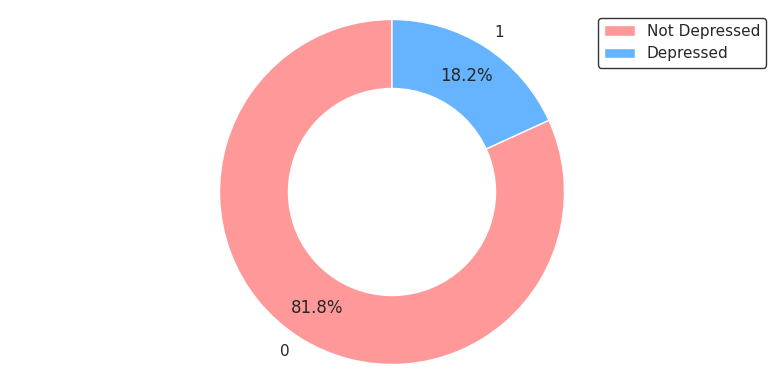

In [10]:
# Target label distribution
plot_donut_chart(train_df, "Depression", colors=['#ff9999', '#66b3ff'], legend_labels=['Not Depressed', 'Depressed'])

### **Split the data into Working Professional and Student**

In [11]:
# Filter rows by Status
student_df = train_df[train_df['Status'] == 'student']
working_df = train_df[train_df['Status'] == 'working professional']
student_test_df = test_df[test_df['Status'] == 'student']
working_test_df = test_df[test_df['Status'] == 'working professional']

In [12]:
# View info for each dataset
dfp =[("Working Professional", working_df), ("Student", student_df)]
for name, df in dfp:
    print(f"The {name} contains {df.shape[0]} rows and {df.shape[1]} columns.\n")
    get_combined_stats(df)
    print()

The Working Professional contains 112799 rows and 22 columns.



,Column,Datatype,Missing Value Count,% Missing,Zero Value Count,% Zero,Min Value,Max Value,Unique Value Count,Unique Values
0,id,int64,0,0.000000,1,0.00,0.0,140698.0,112799,Many unique values
1,Name,object,0,0.000000,0,0.00,ijra,rohan,380,Many unique values
2,Gender,object,0,0.000000,0,0.00,female,male,2,"[female, male]"
3,Age,float64,0,0.000000,0,0.00,18.0,60.0,43,Many unique values
4,City,object,0,0.000000,0,0.00,aishwarya,kalyan,84,Many unique values
5,Status,object,0,0.000000,0,0.00,working professional,working professional,1,[working professional]
6,Profession,object,8763,7.768686,0,0.00,dev,teacher,64,Many unique values
7,Acad_Pressure,float64,112794,99.995567,0,0.00,2.0,4.0,3,"[nan, 2.0, 4.0, 3.0]"
8,Work_Pressure,float64,20,0.017731,0,0.00,1.0,5.0,5,"[5.0, 4.0, 1.0, 2.0, 3.0, nan]"
9,CGPA,float64,112793,99.994681,0,0.00,5.42,9.72,6,"[nan, 8.14, 8.04, 8.11, 9.72, 5.42, 8.24]"



The Student contains 27901 rows and 22 columns.



,Column,Datatype,Missing Value Count,% Missing,Zero Value Count,% Zero,Min Value,Max Value,Unique Value Count,Unique Values
0,id,int64,0,0.000000,0,0.00,2.0,140699.0,27901,Many unique values
1,Name,object,0,0.000000,0,0.00,taurav,aarav,268,Many unique values
2,Gender,object,0,0.000000,0,0.00,female,male,2,"[male, female]"
3,Age,float64,0,0.000000,0,0.00,18.0,59.0,34,"[33.0, 24.0, 31.0, 28.0, 25.0, 29.0, 30.0, 27.0, 19.0, 20.0, 23.0, 18.0, 21.0, 22.0, 34.0, 32.0, 26.0, 39.0, 35.0, 42.0, 36.0, 58.0, 49.0, 38.0, 51.0, 44.0, 43.0, 46.0, 59.0, 54.0, 48.0, 56.0, 37.0, 41.0]"
4,City,object,0,0.000000,0,0.00,kibara,kalyan,52,Many unique values
5,Status,object,0,0.000000,0,0.00,student,student,1,[student]
6,Profession,object,27867,99.878141,0,0.00,civil engineer,architect,14,"[nan, civil engineer, architect, ux/ui designer, digital marketer, content writer, educational consultant, teacher, student, manager, chef, doctor, lawyer, entrepreneur, pharmacist]"
7,Acad_Pressure,float64,9,0.032257,0,0.00,1.0,5.0,5,"[5.0, 2.0, 3.0, 4.0, 1.0, nan]"
8,Work_Pressure,float64,27898,99.989248,0,0.00,2.0,5.0,2,"[nan, 5.0, 2.0]"
9,CGPA,float64,9,0.032257,0,0.00,5.03,10.0,331,Many unique values


#### **Observations**
---
- **Working Professional**: The dataset is heavily imbalanced in terms of the depression distribution, with most working professionals not being depressed (92% vs 8%). **Acad_Pressure, CGPA, Study_Sat** have a significantly high percentage of missing values (>99%) and will be removed.
- **Student**: The depression rate among students is 59%, which is much higher than the 8.2% observed in working professionals. The students' dataset is relatively balanced. **Work_Pressure, Profession, Job_Sat** have a significantly high percentage of missing values (~100%) and will be removed.

# **Data Preprocessing**
---

In [13]:
# Create a function to display column value counts and percent 
def cat_col_dist(df, *cols):
    # Calculate value counts and percentages
    grouped = df.groupby(list(cols)).size().reset_index(name='Count')
    grouped['Percentage'] = (grouped['Count'] / len(df)) * 100
    grouped = grouped.sort_values(by="Percentage", ascending=False).reset_index(drop=True)

    # Create a DataFrame with counts and percentages
    print(f"Distribution for {', '.join(cols)}\n")
    display(grouped)
    print("----------" * 10)

In [14]:
# Drop columns with high % missing values
dfw = [("train-Working Professional", working_df), ("test-Working Professional",working_test_df)]
dfk = [("train-Student", student_df), ("test-Student", student_test_df)]

for name, df in dfw:
    df.drop(columns=["Acad_Pressure", "CGPA", "Study_Sat"], inplace=True)

for name, df in dfk:
    df.drop(columns=["Work_Pressure", "Profession", "Job_Sat"], inplace=True)

### **Profession**

In [15]:
# Unique values for Profession
cat_col_dist(train_df, 'Profession')

Distribution for Profession



,Profession,Count,Percentage
0,teacher,24906,17.701493
1,content writer,7814,5.553660
2,architect,4370,3.105899
3,consultant,4229,3.005686
4,hr manager,4022,2.858564
5,pharmacist,3893,2.766880
6,doctor,3255,2.313433
7,business analyst,3161,2.246624
8,entrepreneur,2968,2.109453
9,chemist,2967,2.108742


----------------------------------------------------------------------------------------------------


In [16]:
# Define profession mapping and valid professions
valid_professions = [
    'teacher', 'content writer', 'architect', 'consultant', 'hr manager', 
    'pharmacist', 'doctor', 'business analyst', 'entrepreneur', 'chemist', 
    'chef', 'educational consultant', 'data scientist', 'researcher', 'lawyer',
    'customer support', 'marketing manager', 'pilot', 'travel consultant', 'plumber', 
    'sales executive', 'manager', 'judge', 'electrician', 'financial analyst', 
    'software engineer', 'civil engineer', 'ux/ui designer', 'digital marketer', 
    'accountant', 'finanancial analyst', 'mechanical engineer', 
    'graphic designer', 'research analyst', 'investment banker', 'student', 
    'family consultant', 'analyst', 'medical doctor', 'city manager', 'unemployed'
]

profession_mapping = {
    'teacher': 'education',
    'content writer': 'creative',
    'architect': 'design_engineering',
    'consultant': 'business_management',
    'hr manager': 'business_management',
    'pharmacist': 'healthcare',
    'doctor': 'healthcare',
    'business analyst': 'business_management',
    'entrepreneur': 'other',
    'chemist': 'healthcare',
    'chef': 'hospitality',
    'educational consultant': 'education',
    'data scientist': 'technology',
    'researcher': 'education',
    'lawyer': 'law_governance',
    'customer support': 'customer_service',
    'marketing manager': 'business_management',
    'pilot': 'hospitality',
    'travel consultant': 'hospitality',
    'plumber': 'trades_technical',
    'sales executive': 'business_management',
    'manager': 'business_management',
    'judge': 'law_governance',
    'electrician': 'trades_technical',
    'financial analyst': 'finance',
    'software engineer': 'technology',
    'civil engineer': 'engineering',
    'ux/ui designer': 'creative',
    'digital marketer': 'technology',
    'accountant': 'finance',
    'finanancial analyst': 'finance',
    'mechanical engineer': 'engineering',
    'graphic designer': 'creative',
    'research analyst': 'education',
    'investment banker': 'finance',
    'student': 'other',
    'family consultant': 'other',
    'analyst': 'business_management',
    'medical doctor': 'healthcare',
    'city manager': 'law_governance',
    'unemployed': 'other'
}

In [17]:
# Clean Profession column and create a new Profession Group column
for name, df in dfw:
    print(f"{name}")
    df['Prof_Grp'] = df['Profession'].apply(lambda x: profession_mapping[x] if pd.notna(x) and x in profession_mapping else 'unknown')
    cat_col_dist(df, 'Prof_Grp')

train-Working Professional
Distribution for Prof_Grp



,Prof_Grp,Count,Percentage
0,education,30769,27.277724
1,business_management,16864,14.950487
2,creative,10426,9.242990
3,healthcare,10112,8.964618
4,unknown,8799,7.800601
5,hospitality,6633,5.880371
6,technology,5269,4.671141
7,finance,4635,4.109079
8,design_engineering,4362,3.867056
9,law_governance,3924,3.478754


----------------------------------------------------------------------------------------------------
test-Working Professional
Distribution for Prof_Grp



,Prof_Grp,Count,Percentage
0,education,20126,26.824652
1,business_management,11284,15.039719
2,healthcare,6818,9.087274
3,creative,6817,9.085941
4,unknown,5917,7.886389
5,hospitality,4478,5.968438
6,technology,3525,4.698246
7,finance,3052,4.067815
8,design_engineering,2982,3.974516
9,law_governance,2685,3.578664


----------------------------------------------------------------------------------------------------


### **Sleep Duration**

In [18]:
# Unique values for Sleep Duration
cat_col_dist(train_df, 'Sleep_Duration')

Distribution for Sleep_Duration



,Sleep_Duration,Count,Percentage
0,less than 5 hours,38784,27.565032
1,7-8 hours,36969,26.275053
2,more than 8 hours,32726,23.259417
3,5-6 hours,32142,22.844350
4,3-4 hours,12,0.008529
5,6-7 hours,8,0.005686
6,4-5 hours,7,0.004975
7,2-3 hours,5,0.003554
8,4-6 hours,5,0.003554
9,6-8 hours,4,0.002843


----------------------------------------------------------------------------------------------------


In [19]:
sleep_grouping = {
    # Less than 5 hours
    '3-4 hours': 'le5hours',
    '2-3 hours': 'le5hours',
    '1-2 hours': 'le5hours',
    '1-3 hours': 'le5hours',
    'less than 5 hours': 'le5hours',
    
    # 5-8 hours
    '4-5 hours': '5_8hours',
    '4-6 hours': '5_8hours',
    '3-6 hours': '5_8hours',
    '5-6 hours': '5_8hours',
    '6-7 hours': '5_8hours',
    '6-8 hours': '5_8hours',
    '8 hours': '5_8hours',
    
    # More than 8 hours
    '8-9 hours': 'ge8hours',
    '9-11 hours': 'ge8hours',
    '10-11 hours': 'ge8hours',
    'more than 8 hours': 'ge8hours'
}

In [20]:
sleep_mapping = {'le5hours' : 1, '5_8hours': 3, 'ge8hours': 5, 'unknown':-1}

# Clean Dietary Habits column
for group in [dfk, dfw]:
    for name, df in group:
        print(f"{name}")
        df['Sleep_Duration'] = df['Sleep_Duration'].replace(sleep_grouping)
        df['Sleep_Durations'] = df['Sleep_Duration'].apply(lambda x: x if x in ['le5hours', '5_8hours', 'ge8hours'] else "unknown")
        df['Sleep_Duration'] = df['Sleep_Durations'].map(sleep_mapping)
        cat_col_dist(df, 'Sleep_Durations', 'Sleep_Duration')

train-Student
Distribution for Sleep_Durations, Sleep_Duration



,Sleep_Durations,Sleep_Duration,Count,Percentage
0,le5hours,1,8315,29.801799
1,unknown,-1,7351,26.346726
2,5_8hours,3,6189,22.182001
3,ge8hours,5,6046,21.669474


----------------------------------------------------------------------------------------------------
test-Student
Distribution for Sleep_Durations, Sleep_Duration



,Sleep_Durations,Sleep_Duration,Count,Percentage
0,le5hours,1,5588,29.767739
1,unknown,-1,4877,25.980183
2,5_8hours,3,4185,22.293842
3,ge8hours,5,4122,21.958236


----------------------------------------------------------------------------------------------------
train-Working Professional
Distribution for Sleep_Durations, Sleep_Duration



,Sleep_Durations,Sleep_Duration,Count,Percentage
0,le5hours,1,30488,27.028608
1,unknown,-1,29646,26.282148
2,ge8hours,5,26686,23.658011
3,5_8hours,3,25979,23.031233


----------------------------------------------------------------------------------------------------
test-Working Professional
Distribution for Sleep_Durations, Sleep_Duration



,Sleep_Durations,Sleep_Duration,Count,Percentage
0,le5hours,1,20083,26.767340
1,unknown,-1,19635,26.170230
2,ge8hours,5,18075,24.091006
3,5_8hours,3,17235,22.971424


----------------------------------------------------------------------------------------------------


### **Dietary Habits**

In [21]:
# Unique values for Dietary Habits
cat_col_dist(train_df, 'Diet_Habits')

Distribution for Diet_Habits



,Diet_Habits,Count,Percentage
0,moderate,49705,35.326937
1,unhealthy,46227,32.855011
2,healthy,44741,31.798863
3,yes,2,0.001421
4,no,2,0.001421
5,more healthy,2,0.001421
6,m.tech,1,0.000711
7,vegas,1,0.000711
8,pratham,1,0.000711
9,no healthy,1,0.000711


----------------------------------------------------------------------------------------------------


In [22]:
# Define valid categories and mappings
valid_diet_habits = ['moderate', 'unhealthy', 'healthy']
diet_grouping = {
    # Map similar or misspelled categories
    'more healthy': 'healthy',
    'less healthy': 'unhealthy',
    'less than healthy': 'unhealthy',
    'no healthy': 'unhealthy'
}

In [23]:
diet_mapping = {'healthy': 5, 'moderate': 3, 'unhealthy': 1, 'unknown':-1}

# Clean Dietary Habits column
for group in [dfk, dfw]:
    for name, df in group:
        print(f"{name}")
        df['Diet_Habits'] = df['Diet_Habits'].replace(diet_grouping)
        df['Dietary_Habits'] = df['Diet_Habits'].apply(lambda x: x if x in valid_diet_habits else 'unknown')
        df['Diet_Habits'] = df['Dietary_Habits'].map(diet_mapping)
        cat_col_dist(df, 'Dietary_Habits', 'Diet_Habits')

train-Student
Distribution for Dietary_Habits, Diet_Habits



,Dietary_Habits,Diet_Habits,Count,Percentage
0,unhealthy,1,10320,36.987922
1,moderate,3,9921,35.557865
2,healthy,5,7651,27.421956
3,unknown,-1,9,0.032257


----------------------------------------------------------------------------------------------------
test-Student
Distribution for Dietary_Habits, Diet_Habits



,Dietary_Habits,Diet_Habits,Count,Percentage
0,unhealthy,1,6908,36.799489
1,moderate,3,6583,35.068187
2,healthy,5,5272,28.084381
3,unknown,-1,9,0.047944


----------------------------------------------------------------------------------------------------
train-Working Professional
Distribution for Dietary_Habits, Diet_Habits



,Dietary_Habits,Diet_Habits,Count,Percentage
0,moderate,3,39784,35.269816
1,healthy,5,37092,32.883270
2,unhealthy,1,35910,31.835389
3,unknown,-1,13,0.011525


----------------------------------------------------------------------------------------------------
test-Working Professional
Distribution for Dietary_Habits, Diet_Habits



,Dietary_Habits,Diet_Habits,Count,Percentage
0,moderate,3,26435,35.233513
1,healthy,5,24696,32.915711
2,unhealthy,1,23879,31.826785
3,unknown,-1,18,0.023991


----------------------------------------------------------------------------------------------------


### **Degree**

In [24]:
# Unique values for Degree
cat_col_dist(train_df, 'Degree')

Distribution for Degree



,Degree,Count,Percentage
0,class 12,14729,10.468372
1,b.ed,11691,8.309168
2,b.arch,8742,6.213220
3,b.com,8113,5.766169
4,b.pharm,5856,4.162047
5,bca,5739,4.078891
6,m.ed,5668,4.028429
7,mca,5234,3.719972
8,bba,5030,3.574982
9,bsc,5027,3.572850


----------------------------------------------------------------------------------------------------


In [25]:
# Define dictionaries for educational level and fields
ed_level_mapping = {
    "high_school": ["class 12", "class 11"],
    "bachelor": ["b.ed", "b.arch", "b.com", "b.pharm", "bpharm", "bca", "bba", "bsc", "b.sc", "b.tech", "llb", "ll b.ed", "ba", "mbbs", "be", "bhm", "bpa"],
    "master": ["m.ed", "mca", "msc", "m.com", "mcom", "llm", "m.pharm", "mpharm", "m.tech", "mtech", "mba", "ma", "mhm", "me", "m.arch"],
    "doctorate": ["phd", "md"]
}

ed_field_mapping = {
    "commerce": ["b.com", "m.com", "mcom", "mba", "p.com"],
    "education": ["b.ed", "m.ed", "ll b.ed"],
    "engineering": ["bca", "mca", "b.tech", "m.tech", "be", "me"],
    "healthcare": ["b.pharm", "m.pharm", "mbbs", "md", "bpharm"],
    "law": ["llb", "llm", "ll b.ed", "llba"],
    "architecture": ["b.arch", "m.arch"],
    "science": ["bsc", "b.sc", "msc", "phd"],
    "business_management": ["bba", "mba"],
    "hospitality": ["bhm", "mhm"],
    "arts_humanities": ["ba", "ma", "bpa"]
}

In [26]:
# Clean Profession column and create a new Profession Group column
ed_level_grouping = {value: key for key, values in ed_level_mapping.items() for value in values}
ed_field_grouping = {value: key for key, values in ed_field_mapping.items() for value in values}
ed_level_mapping = {'high_school': 1, 'bachelor': 2, 'master': 3,'doctorate': 4, 'unknown':-1}

for group in [dfk, dfw]:
    for name, df in group:
        print(f"{name}")
        df['Ed_Levels'] = df['Degree'].apply(lambda x: ed_level_grouping[x] if pd.notna(x) and x in ed_level_grouping else 'unknown')
        df['Ed_Level'] = df['Ed_Levels'].map(ed_level_mapping)
        df['Ed_Field'] = df['Degree'].apply(lambda x: ed_field_grouping[x] if pd.notna(x) and x in ed_field_grouping else 'unknown')
        cat_col_dist(df, 'Ed_Levels', 'Ed_Level')
        cat_col_dist(df, 'Ed_Field')

train-Student
Distribution for Ed_Levels, Ed_Level



,Ed_Levels,Ed_Level,Count,Percentage
0,bachelor,2,13339,47.808322
1,master,3,7357,26.368231
2,high_school,1,6081,21.794918
3,doctorate,4,1094,3.921006
4,unknown,-1,30,0.107523


----------------------------------------------------------------------------------------------------
Distribution for Ed_Field



,Ed_Field,Count,Percentage
0,unknown,6110,21.898857
1,engineering,5449,19.529766
2,education,2688,9.634063
3,healthcare,2661,9.537293
4,science,2601,9.322247
5,commerce,2241,8.031970
6,architecture,1478,5.297301
7,business_management,1258,4.508799
8,law,1154,4.136052
9,arts_humanities,1145,4.103796


----------------------------------------------------------------------------------------------------
test-Student
Distribution for Ed_Levels, Ed_Level



,Ed_Levels,Ed_Level,Count,Percentage
0,bachelor,2,9142,48.700192
1,master,3,4888,26.038781
2,high_school,1,4033,21.484125
3,doctorate,4,691,3.681014
4,unknown,-1,18,0.095887


----------------------------------------------------------------------------------------------------
Distribution for Ed_Field



,Ed_Field,Count,Percentage
0,unknown,4052,21.585340
1,engineering,3688,19.646282
2,healthcare,1796,9.567441
3,education,1785,9.508843
4,science,1631,8.688472
5,commerce,1554,8.278287
6,architecture,1088,5.795866
7,business_management,824,4.389516
8,law,813,4.330918
9,arts_humanities,797,4.245685


----------------------------------------------------------------------------------------------------
train-Working Professional
Distribution for Ed_Levels, Ed_Level



,Ed_Levels,Ed_Level,Count,Percentage
0,bachelor,2,59881,53.086464
1,master,3,38807,34.403674
2,high_school,1,8649,7.667621
3,doctorate,4,5392,4.780184
4,unknown,-1,70,0.062057


----------------------------------------------------------------------------------------------------
Distribution for Ed_Field



,Ed_Field,Count,Percentage
0,engineering,21160,18.759032
1,education,14671,13.006321
2,healthcare,14199,12.587878
3,science,10411,9.229692
4,commerce,8968,7.950425
5,unknown,8718,7.728792
6,law,7845,6.954849
7,business_management,7590,6.728783
8,architecture,7269,6.444206
9,hospitality,6475,5.740299


----------------------------------------------------------------------------------------------------
test-Working Professional
Distribution for Ed_Levels, Ed_Level



,Ed_Levels,Ed_Level,Count,Percentage
0,bachelor,2,39948,53.244122
1,master,3,25580,34.093938
2,high_school,1,5779,7.702458
3,doctorate,4,3671,4.892840
4,unknown,-1,50,0.066642


----------------------------------------------------------------------------------------------------
Distribution for Ed_Field



,Ed_Field,Count,Percentage
0,engineering,14078,18.763662
1,education,9684,12.907181
2,healthcare,9511,12.676601
3,science,6856,9.137922
4,commerce,6013,8.014341
5,unknown,5830,7.770432
6,law,5258,7.008050
7,business_management,5033,6.708162
8,architecture,4958,6.608200
9,hospitality,4181,5.572586


----------------------------------------------------------------------------------------------------


### **City**

In [27]:
# Unique values for City
cat_col_dist(train_df, 'City')

Distribution for City



,City,Count,Percentage
0,kalyan,6591,4.684435
1,patna,5924,4.210377
2,vasai-virar,5765,4.097370
3,kolkata,5689,4.043355
4,ahmedabad,5613,3.989339
5,meerut,5528,3.928927
6,ludhiana,5226,3.714286
7,pune,5210,3.702914
8,rajkot,5207,3.700782
9,visakhapatnam,5176,3.678749


----------------------------------------------------------------------------------------------------


In [28]:
city_mapping = {
    'tolkata': 'kolkata',
    'molkata': 'kolkata',
    'khaziabad': 'ghaziabad',
    'nalyan': 'kalyan',
    'less delhi': 'delhi',
    'vasai-virar': 'vasai_virar'
}

valid_cities = [
    'ludhiana', 'varanasi', 'visakhapatnam', 'mumbai', 'kanpur', 'ahmedabad', 'thane', 'nashik', 'bangalore', 'patna', 'rajkot', 'jaipur', 
    'pune', 'lucknow', 'meerut', 'agra', 'surat', 'faridabad', 'hyderabad', 'srinagar', 'ghaziabad', 'kolkata', 'chennai', 'kalyan', 'nagpur', 
    'vadodara', 'delhi', 'bhopal', 'indore', 'gurgaon', 'vasai_virar'
]

In [29]:
# Clean City
for group in [dfk, dfw]:
    for name, df in group:
        print(f"{name}")
        df['City'] = df['City'].replace(city_mapping)
        df['City'] = df['City'].apply(lambda x: x if x in valid_cities else "unknown")
        cat_col_dist(df, 'City')

train-Student
Distribution for City



,City,Count,Percentage
0,kalyan,1571,5.630623
1,srinagar,1372,4.917386
2,hyderabad,1340,4.802695
3,vasai_virar,1290,4.623490
4,lucknow,1155,4.139637
5,thane,1139,4.082291
6,ludhiana,1111,3.981936
7,agra,1094,3.921006
8,surat,1078,3.863661
9,kolkata,1066,3.820652


----------------------------------------------------------------------------------------------------
test-Student
Distribution for City



,City,Count,Percentage
0,kalyan,1078,5.742595
1,srinagar,989,5.268485
2,vasai_virar,922,4.911570
3,hyderabad,841,4.480077
4,lucknow,766,4.080545
5,kolkata,760,4.048583
6,agra,759,4.043256
7,ludhiana,748,3.984658
8,thane,746,3.974004
9,surat,714,3.803537


----------------------------------------------------------------------------------------------------
train-Working Professional
Distribution for City



,City,Count,Percentage
0,kalyan,5021,4.451281
1,patna,4917,4.359081
2,meerut,4703,4.169363
3,ahmedabad,4662,4.133015
4,kolkata,4626,4.101100
5,vasai_virar,4475,3.967234
6,rajkot,4391,3.892765
7,mumbai,4267,3.782835
8,pune,4242,3.760672
9,indore,4229,3.749147


----------------------------------------------------------------------------------------------------
test-Working Professional
Distribution for City



,City,Count,Percentage
0,kalyan,3309,4.410353
1,patna,3234,4.310391
2,meerut,3158,4.209095
3,ahmedabad,3028,4.035827
4,vasai_virar,2975,3.965186
5,kolkata,2966,3.953191
6,rajkot,2856,3.806579
7,ludhiana,2797,3.727942
8,mumbai,2729,3.637309
9,pune,2722,3.627979


----------------------------------------------------------------------------------------------------


# **Univariate/Bivariate Analysis**
---

In [30]:
# Select columns for visualization
working_df2 = working_df[['Gender', 'Age', 'City', 'Prof_Grp', 'Ed_Levels', 'Ed_Field', 'Work_Pressure', 'Job_Sat', 'Sleep_Durations', 'Dietary_Habits', 
                          'Suicidal_Thought', 'Work_Study_Hours', 'Fin_Stress', 'Family_History_MIs', 'Depression']]
student_df2 = student_df[['Gender', 'Age', 'City', 'Ed_Levels', 'Ed_Field', 'CGPA', 'Acad_Pressure', 'Study_Sat', 'Sleep_Durations', 'Dietary_Habits', 
                          'Suicidal_Thought', 'Work_Study_Hours', 'Fin_Stress', 'Family_History_MIs', 'Depression']]

In [31]:
def plot_univariate_and_bivariate(df, depression_col='Depression', top_n=20):
    """
    Plots univariate column distributions and bivariate relationships with the Depression column side by side.
    
    Parameters:
    - df: DataFrame containing the data.
    - depression_col: The column to compare with (e.g., 'Depression').
    - top_n: Maximum number of unique values to display for high-cardinality columns.
    """
    # Ensure the depression column exists
    if depression_col not in df.columns:
        raise ValueError(f"Column '{depression_col}' not found in the DataFrame.")

    # Define a consistent color palette for Depression values
    color_palette = {0: '#1f77b4', 1: '#ff7f0e'}

    # Remove the depression column from the plotting loop
    cols_to_plot = [col for col in df.columns if col != depression_col]
    num_cols = len(cols_to_plot)
    
    # Set a white background style
    plt.style.use('default')

    # Create subplots: Two plots (univariate and bivariate) per column
    fig, axes = plt.subplots(nrows=num_cols, ncols=2, figsize=(12, num_cols * 6))
    axes = axes.reshape(-1, 2)  # Ensure consistent shape for 2 columns per row

    for i, col in enumerate(cols_to_plot):
        # Univariate Plot
        ax_univariate = axes[i, 0]
        if pd.api.types.is_numeric_dtype(df[col]):  # Numerical columns
            sns.histplot(df[col].dropna(), kde=True, ax=ax_univariate, bins=30)
            ax_univariate.set_title(f'Univariate: {col}', fontweight='bold', fontsize=12)
            ax_univariate.set_xlabel(col, fontweight='bold', fontsize=10)
        else:  # Categorical columns
            if df[col].nunique() > top_n: 
                top_values = df[col].value_counts().nlargest(top_n)
                data = df[col].apply(lambda x: x if x in top_values.index else 'Other')
            else:
                data = df[col]
            sns.countplot(y=data, order=data.value_counts().index, ax=ax_univariate)
            ax_univariate.set_title(f'Univariate: {col}', fontweight='bold', fontsize=12)
            ax_univariate.set_xlabel('Count', fontweight='bold', fontsize=10)

        # Bivariate Plot
        ax_bivariate = axes[i, 1]
        if pd.api.types.is_numeric_dtype(df[col]): 
            sns.boxplot(data=df, x=depression_col, y=col, ax=ax_bivariate, order=sorted(df[depression_col].unique()), width=0.6)
            for patch, category in zip(ax_bivariate.patches, sorted(df[depression_col].unique())):
                patch.set_facecolor(color_palette[category])
            ax_bivariate.set_title(f'Bivariate: {col} vs {depression_col}', fontweight='bold', fontsize=12)
            ax_bivariate.set_xlabel(depression_col, fontweight='bold', fontsize=10)
            ax_bivariate.set_ylabel(col, fontweight='bold', fontsize=10)
        else:  # Categorical columns
            if df[col].nunique() > top_n:  # Handle high cardinality
                top_values = df[col].value_counts().nlargest(top_n)
                data = df[col].apply(lambda x: x if x in top_values.index else 'Other')
            else:
                data = df[col]
            cross_tab = pd.crosstab(data, df[depression_col])
            cross_tab_norm = cross_tab.div(cross_tab.sum(axis=1), axis=0)  
            cross_tab_norm.plot(kind='bar', stacked=True, ax=ax_bivariate, color=[color_palette[cat] for cat in cross_tab.columns])
            ax_bivariate.set_title(f'Bivariate: {col} vs {depression_col}', fontweight='bold', fontsize=12)
            ax_bivariate.set_xlabel(col, fontweight='bold', fontsize=10)
            ax_bivariate.set_ylabel('Proportion', fontweight='bold', fontsize=10)

        # Customize axes: Show only bottom and left spines
        for ax in [ax_univariate, ax_bivariate]:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_color('black')
            ax.spines['left'].set_color('black')
            ax.tick_params(bottom=True, left=True, right=False, top=False)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

Working Professional


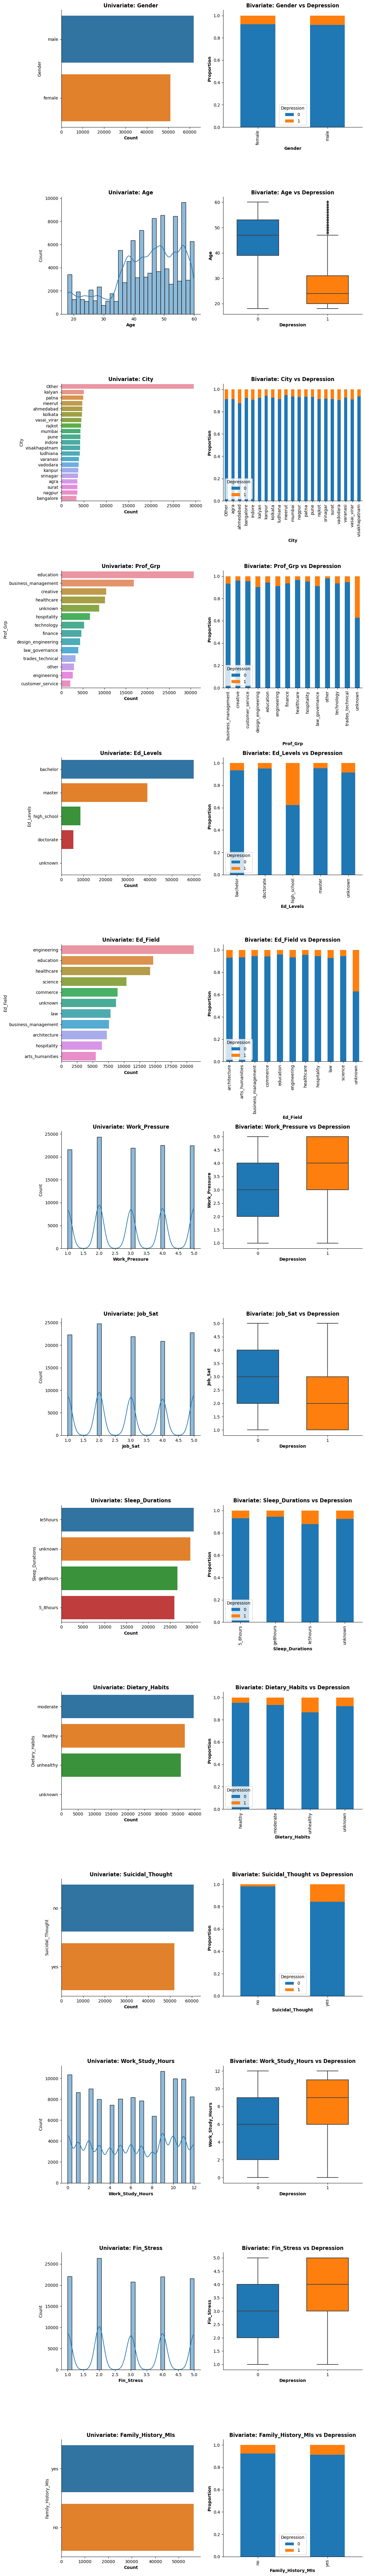

------------------------------------------------------------------------------------------------------------------------
Student


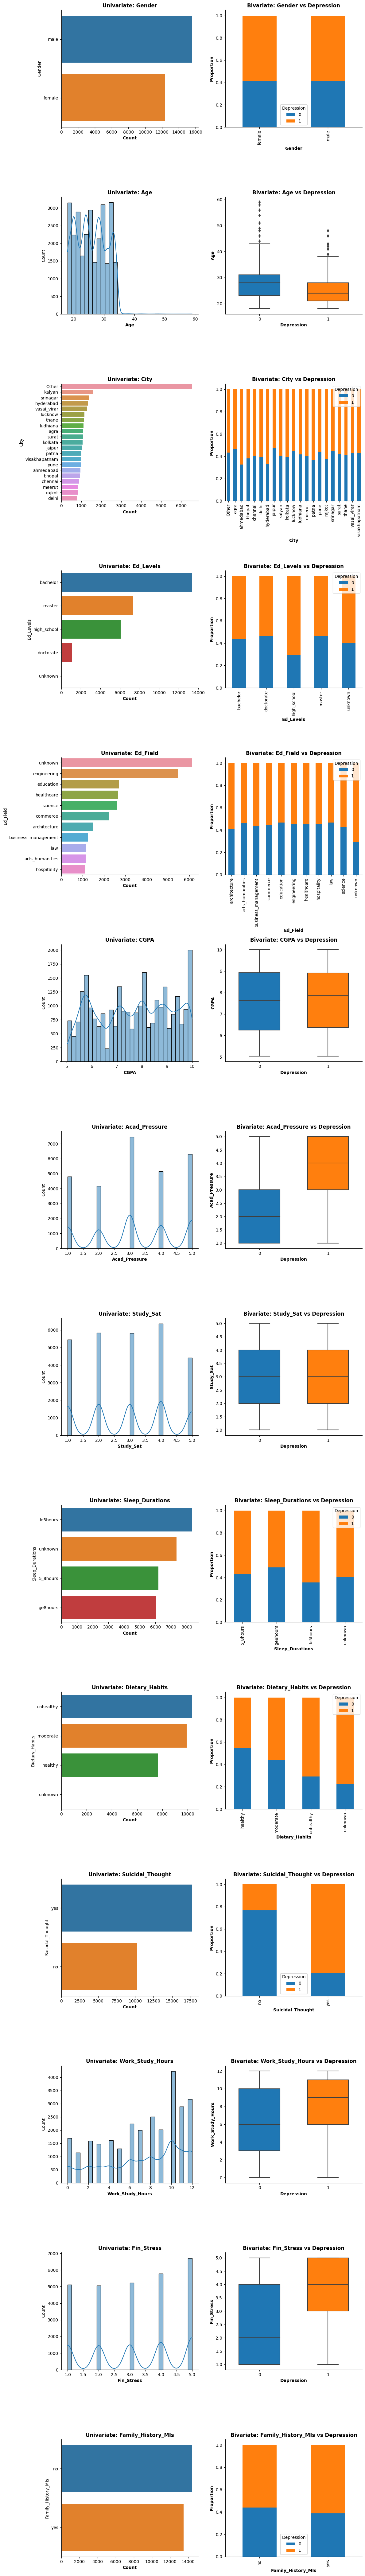

------------------------------------------------------------------------------------------------------------------------


In [32]:
for name, df in [("Working Professional", working_df2), ("Student", student_df2)]:
    print(f"{name}")
    plot_univariate_and_bivariate(df, depression_col='Depression', top_n=20)
    print("---------------"*8)

Working Professional


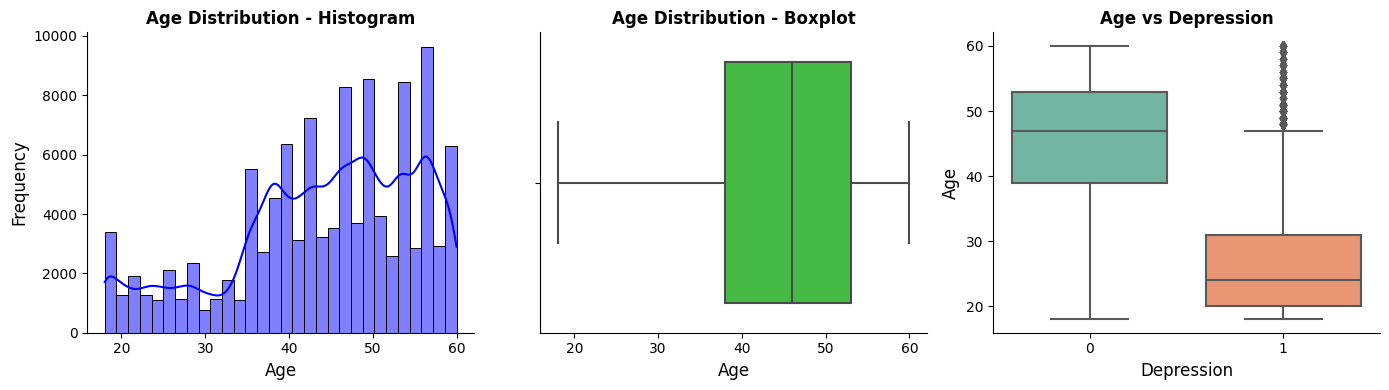

Student


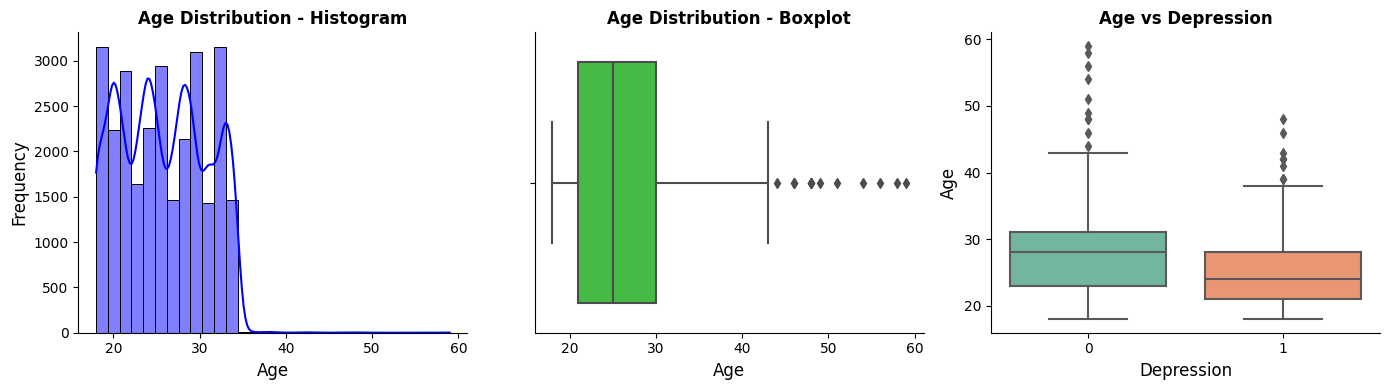

------------------------------------------------------------------------------------------------------------------------


In [33]:
# Visualize Age column 
for name, df in dfp:
    print(f"{name}")
    plt.figure(figsize=(14, 4))
    plt.style.use('default')

    # Histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df["Age"], bins=30, kde=True, color="blue")
    plt.title("Age Distribution - Histogram", fontsize=12, fontweight="bold")
    plt.xlabel("Age", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['bottom', 'left']].set_color('black')
    
    # Boxplot
    plt.subplot(1, 3, 2)
    sns.boxplot(x=df["Age"], color="limegreen")
    plt.title("Age Distribution - Boxplot", fontsize=12, fontweight="bold")
    plt.xlabel("Age", fontsize=12)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['bottom', 'left']].set_color('black')

    # Bivariate Analysis
    plt.subplot(1, 3, 3)
    sns.boxplot(x=df["Depression"], y=df["Age"], palette="Set2")
    plt.title("Age vs Depression", fontsize=12, fontweight="bold")
    plt.xlabel("Depression", fontsize=12)
    plt.ylabel("Age", fontsize=12)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['bottom', 'left']].set_color('black')
    
    plt.tight_layout()
    plt.show()

print("---------------"*8)

Working Professional


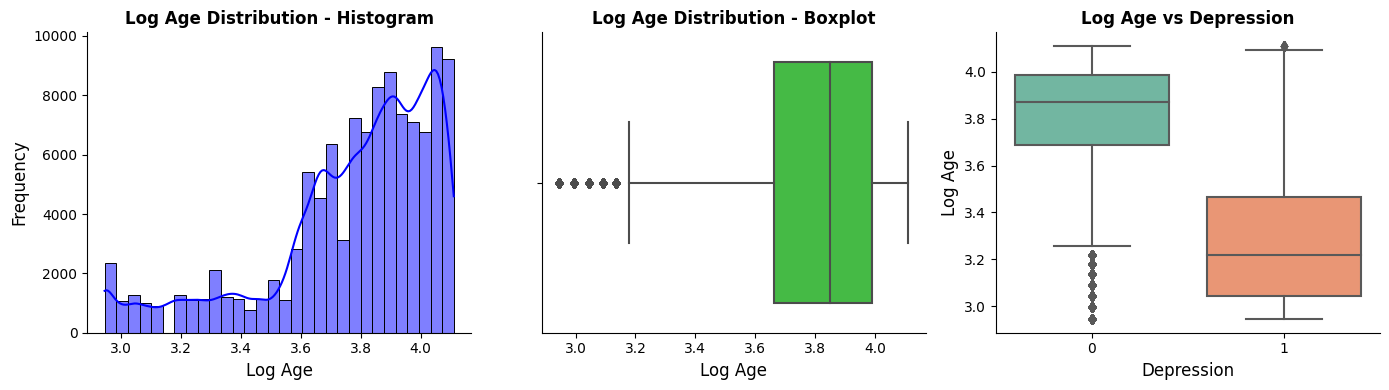

Student


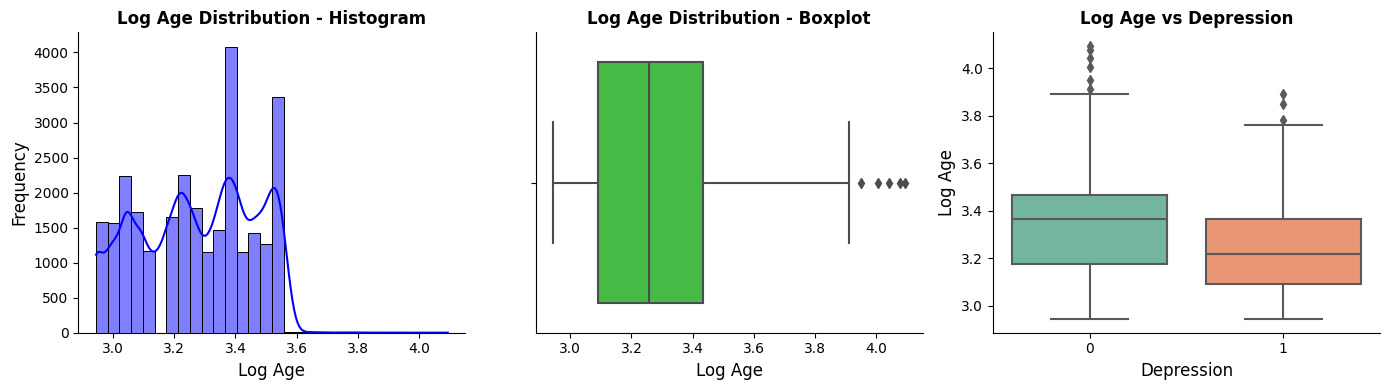

------------------------------------------------------------------------------------------------------------------------


In [34]:
# Visualize Age column 
for name, df in dfp:
    print(f"{name}")
    df["Agelg"] = np.log1p(df["Age"])
    plt.figure(figsize=(14, 4))
    plt.style.use('default')

    # Histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df["Agelg"], bins=30, kde=True, color="blue")
    plt.title("Log Age Distribution - Histogram", fontsize=12, fontweight="bold")
    plt.xlabel("Log Age", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['bottom', 'left']].set_color('black')
    
    # Boxplot
    plt.subplot(1, 3, 2)
    sns.boxplot(x=df["Agelg"], color="limegreen")
    plt.title("Log Age Distribution - Boxplot", fontsize=12, fontweight="bold")
    plt.xlabel("Log Age", fontsize=12)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['bottom', 'left']].set_color('black')

    # Bivariate Analysis
    plt.subplot(1, 3, 3)
    sns.boxplot(x=df["Depression"], y=df["Agelg"], palette="Set2")
    plt.title("Log Age vs Depression", fontsize=12, fontweight="bold")
    plt.xlabel("Depression", fontsize=12)
    plt.ylabel("Log Age", fontsize=12)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['bottom', 'left']].set_color('black')
    
    plt.tight_layout()
    plt.show()

print("---------------"*8)

In [35]:
# Create a column for log Age
for name, df in dfw:
    df["Agelg"] = np.log1p(df["Age"])

for name, df in dfk:
    df["Agelg"] = np.log1p(df["Age"])

In [36]:
"""
# Define the bins
bins = range(0, 101, 5)

# Use numerical labels instead of strings
numerical_labels = list(range(len(bins) - 1))

# Create the mapping table
mapping_table = {num_label: f"{bins[i]}-{bins[i+1]-1}" for i, num_label in enumerate(numerical_labels)}
display(mapping_table)

for name, df in dfw:
    df['Age_Bin'] = pd.cut(df['Age'], bins=bins, labels=numerical_labels, right=False)

for name, df in dfk:
    df['Age_Bin'] = pd.cut(df['Age'], bins=bins, labels=numerical_labels, right=False)
"""

'\n# Define the bins\nbins = range(0, 101, 5)\n\n# Use numerical labels instead of strings\nnumerical_labels = list(range(len(bins) - 1))\n\n# Create the mapping table\nmapping_table = {num_label: f"{bins[i]}-{bins[i+1]-1}" for i, num_label in enumerate(numerical_labels)}\ndisplay(mapping_table)\n\nfor name, df in dfw:\n    df[\'Age_Bin\'] = pd.cut(df[\'Age\'], bins=bins, labels=numerical_labels, right=False)\n\nfor name, df in dfk:\n    df[\'Age_Bin\'] = pd.cut(df[\'Age\'], bins=bins, labels=numerical_labels, right=False)\n'

In [37]:
'''
# Define a function to cap the upper outliers 
def cap_upper_outliers_to_whisker(df, col):
    Q1 = df[col].quantile(0.25)  # First quartile
    Q3 = df[col].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile range
    upper_whisker = Q3 + 1.5 * IQR  # Upper whisker
        
    # Cap values greater than the upper whisker
    df[col] = np.where(df[col] > upper_whisker, upper_whisker, df[col])
    
    return df[col]

# Apply the function to Age
student_df["Agelg"] = cap_upper_outliers_to_whisker(student_df, "Agelg")
'''

'\n# Define a function to cap the upper outliers \ndef cap_upper_outliers_to_whisker(df, col):\n    Q1 = df[col].quantile(0.25)  # First quartile\n    Q3 = df[col].quantile(0.75)  # Third quartile\n    IQR = Q3 - Q1  # Interquartile range\n    upper_whisker = Q3 + 1.5 * IQR  # Upper whisker\n        \n    # Cap values greater than the upper whisker\n    df[col] = np.where(df[col] > upper_whisker, upper_whisker, df[col])\n    \n    return df[col]\n\n# Apply the function to Age\nstudent_df["Agelg"] = cap_upper_outliers_to_whisker(student_df, "Agelg")\n'

In [38]:
# Perform t-test to compare the means of the two groups
for name, df in dfp:
    print(f"{name}")
    num_cols = df.select_dtypes(include=["int", "float"]).columns
    depress_df = df[df["Depression"] == 1]
    non_depress_df = df[df["Depression"] == 0]

    for col in num_cols:
        stat, p_value = ttest_ind(depress_df[col].dropna(), non_depress_df[col].dropna(), nan_policy='omit')
        print(f"T-test for {col}:")
        print(f"Statistic: {stat:.6f}, p-value: {p_value}")
        if p_value < 0.05:
            print(f"There is a significant difference in {col} between depressed and non-depressed individuals.\n")
        else:
            print(f"There is no significant difference in {col} between depressed and non-depressed individuals.\n")

Working Professional
T-test for id:
Statistic: 1.838250, p-value: 0.06602818019932177
There is no significant difference in id between depressed and non-depressed individuals.

T-test for Age:
Statistic: -179.298158, p-value: 0.0
There is a significant difference in Age between depressed and non-depressed individuals.

T-test for Work_Pressure:
Statistic: 74.511066, p-value: 0.0
There is a significant difference in Work_Pressure between depressed and non-depressed individuals.

T-test for Job_Sat:
Statistic: -57.416242, p-value: 0.0
There is a significant difference in Job_Sat between depressed and non-depressed individuals.

T-test for Sleep_Duration:
Statistic: -15.186934, p-value: 4.860700174926054e-52
There is a significant difference in Sleep_Duration between depressed and non-depressed individuals.

T-test for Diet_Habits:
Statistic: -41.283720, p-value: 0.0
There is a significant difference in Diet_Habits between depressed and non-depressed individuals.

T-test for Work_Study_Ho

Correlation Heatmap for Working Professional:



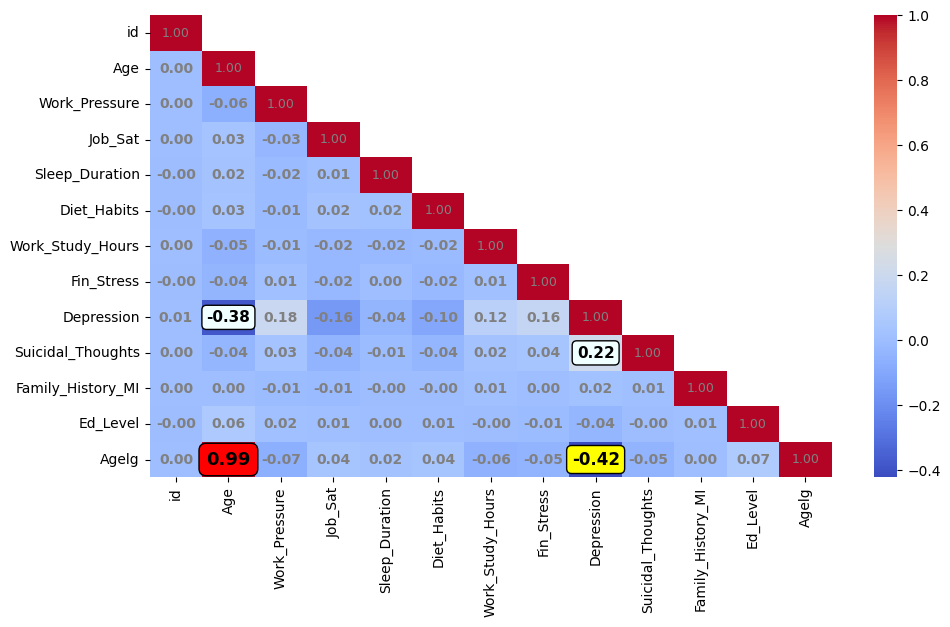

Correlation Heatmap for Student:



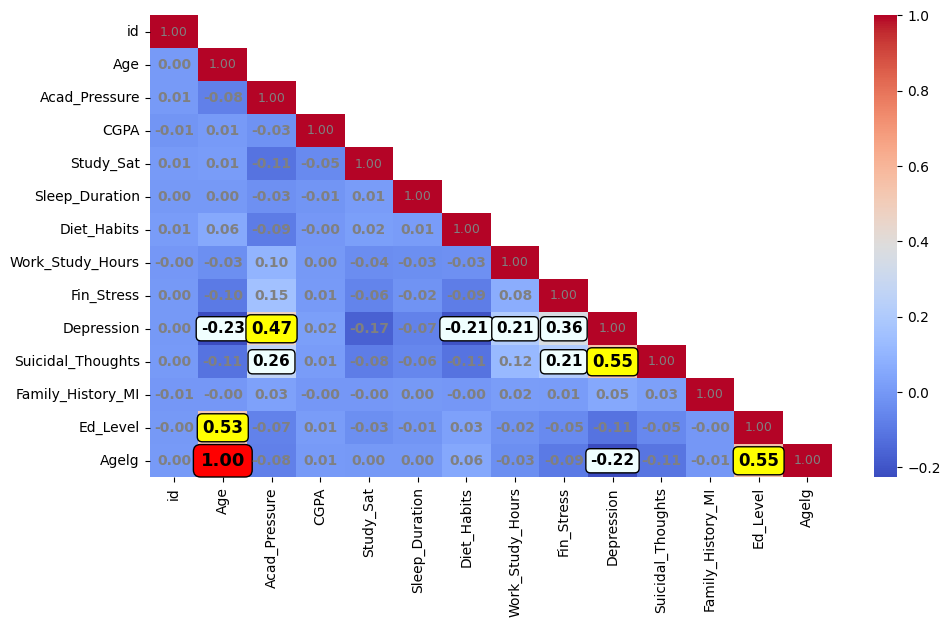

In [39]:
# Correlations
for name, df in dfp: 
    print(f"Correlation Heatmap for {name}:\n")
    
    plt.figure(figsize=(11, 6))
    corr = df.dropna().corr(numeric_only=True)
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    sns.heatmap(corr, annot=False, cmap="coolwarm", mask=mask)
    
    for i in range(len(corr.columns)):
        for j in range(i+1):
            value = corr.iloc[i, j]
            if abs(value) == 1:
                bbox_props = None
                text_color = 'grey'
                weight = 'normal'
                font_size = 9
            elif abs(value) >= 0.7:
                bbox_props = dict(boxstyle='round,pad=0.4',
                                  facecolor='red', edgecolor='black')
                text_color = 'black'
                weight = 900
                font_size = 13
            elif abs(value) >= 0.4:
                bbox_props = dict(boxstyle='round,pad=0.3',
                                  facecolor='yellow', edgecolor='black')
                text_color = 'black'
                weight = 800
                font_size = 12
            elif abs(value) >= 0.2:
                bbox_props = dict(boxstyle='round,pad=0.3',
                                  facecolor='azure', edgecolor='black')
                text_color = 'black'
                weight = 700
                font_size = 11
            else:
                bbox_props = None
                text_color = 'grey'
                weight = 600
                font_size = 10
    
            plt.gca().text(j+0.5, i+0.5, f'{value:.2f}', ha='center', va='center',
                           color=text_color, fontsize=font_size, fontweight=weight, bbox=bbox_props)
    plt.gca().grid(False)
    plt.show()

In [40]:
# Perform chi2 test to check for association between variables and Cramer's V to review the strength of relationship between variables
'''
Strength for correlation if range for abs(corr) between 2 independent variables is
- (0.25, ) : Very Strong (Drop one of the variables)
- (0.15, 0.25) : Strong (Keep)
- (0.10, 0.15) : Moderate (Keep)
- (0.05, 0.10) : Weak (Keep)
- (0, 0.05) : Very Weak (Keep)

Strength for correlation if range for abs(corr) between an independent and a dependent variable is
- (0.25, ) : Very Strong (Keep)
- (0.15, 0.25) : Strong (Keep)
- (0.10, 0.15) : Moderate (Keep)
- (0.05, 0.10) : Weak (Keep)
- (0, 0.05) : Very Weak (Drop)
'''

# Function to calculate Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


# List of categorical variables
col_unique_cat = ['Depression', 'Gender', 'City', 'Profession', 'Work_Pressure', 'Sleep_Duration', 'Diet_Habits', 'Suicidal_Thought', 'Work_Study_Hours', 'Fin_Stress', 
                  'Family_History_MIs', 'Prof_Grp', 'Ed_Level', 'Ed_Field', 'Job_Sat']

results = []

# Loop through all unique pairs of categorical variables
for col1 in col_unique_cat:
    for col2 in col_unique_cat:
        if col1 != col2:
            # Chi2 Test
            confusion_matrix = pd.crosstab(working_df[col1], working_df[col2])
            chi2, p, _, _ = chi2_contingency(confusion_matrix)
            # Cramer's V
            v = cramers_v(working_df[col1], working_df[col2])
            results.append({"Variable 1": col1, "Variable 2": col2, "Chi2": chi2,
                           "P-value": p, "Association": "YES" if p < 0.05 else "NO", "Cramer's V": v})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Define a function to apply styling based on association
def highlight_association(val):
    return "background-color: limegreen; font-weight: bold" if val == "YES" else ""

# Define a function to apply styling based on Cramer's V

def highlight_cramer(val):
    if val < 0.1:
        return "background-color: grey; font-weight: 500"
    elif val < 0.15:
        return "background-color: lightgray; font-weight: 600"
    elif val < 0.25:
        return "background-color: coral; font-weight: 700"
    else:
        return "background-color: red; font-weight: 800"

# Create a styler object and apply styles to specific columns
# chi2_results_df = results_df[(results_df["Association"]=="YES") & (results_df["Cramer's V"]>0.2)].style.apply(lambda x: [highlight_association(val) if x.name == "Association" else highlight_cramer(val) for val in x], axis=0, subset=["Association", "Cramer's V"])
chi2_results_df = results_df.style.apply(lambda x: [highlight_association(
    val) if x.name == "Association" else highlight_cramer(val) for val in x], axis=0, subset=["Association", "Cramer's V"])
chi2_results_df

,Variable 1,Variable 2,Chi2,P-value,Association,Cramer's V
0,Depression,Gender,6.135296,0.013251,YES,0.006747
1,Depression,City,401.061103,0.000000,YES,0.057278
2,Depression,Profession,1425.848582,0.000000,YES,0.114455
3,Depression,Work_Pressure,6086.462940,0.000000,YES,0.232235
4,Depression,Sleep_Duration,1007.326045,0.000000,YES,0.094360
5,Depression,Diet_Habits,1865.273266,0.000000,YES,0.128490
6,Depression,Suicidal_Thought,7237.954783,0.000000,YES,0.253295
7,Depression,Work_Study_Hours,2701.974739,0.000000,YES,0.154427
8,Depression,Fin_Stress,4519.357824,0.000000,YES,0.200077
9,Depression,Family_History_MIs,33.084183,0.000000,YES,0.016865


In [41]:
# Perform chi2 test to check for association between variables and Cramer's for Student
# List of categorical variables
col_unique_cat = ['Depression', 'Gender', 'City', 'Acad_Pressure', 'Sleep_Duration', 'Diet_Habits', 'Suicidal_Thought', 'Work_Study_Hours', 'Fin_Stress', 
                  'Family_History_MIs', 'Ed_Level', 'Ed_Field', 'Study_Sat']

results = []

# Loop through all unique pairs of categorical variables
for col1 in col_unique_cat:
    for col2 in col_unique_cat:
        if col1 != col2:
            # Chi2 Test
            confusion_matrix = pd.crosstab(student_df[col1], student_df[col2])
            chi2, p, _, _ = chi2_contingency(confusion_matrix)
            # Cramer's V
            v = cramers_v(student_df[col1], student_df[col2])
            results.append({"Variable 1": col1, "Variable 2": col2, "Chi2": chi2,
                           "P-value": p, "Association": "YES" if p < 0.05 else "NO", "Cramer's V": v})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Define a function to apply styling based on association
def highlight_association(val):
    return "background-color: limegreen; font-weight: bold" if val == "YES" else ""

# Define a function to apply styling based on Cramer's V

def highlight_cramer(val):
    if val < 0.1:
        return "background-color: grey; font-weight: 500"
    elif val < 0.15:
        return "background-color: lightgray; font-weight: 600"
    elif val < 0.25:
        return "background-color: coral; font-weight: 700"
    else:
        return "background-color: red; font-weight: 800"

# Create a styler object and apply styles to specific columns
# chi2_results_df = results_df[(results_df["Association"]=="YES") & (results_df["Cramer's V"]>0.2)].style.apply(lambda x: [highlight_association(val) if x.name == "Association" else highlight_cramer(val) for val in x], axis=0, subset=["Association", "Cramer's V"])
chi2_results_df = results_df.style.apply(lambda x: [highlight_association(
    val) if x.name == "Association" else highlight_cramer(val) for val in x], axis=0, subset=["Association", "Cramer's V"])
chi2_results_df

,Variable 1,Variable 2,Chi2,P-value,Association,Cramer's V
0,Depression,Gender,0.082658,0.773727,NO,0.000000
1,Depression,City,165.752544,0.000000,YES,0.069754
2,Depression,Acad_Pressure,6426.717293,0.000000,YES,0.479874
3,Depression,Sleep_Duration,275.199554,0.000000,YES,0.098774
4,Depression,Diet_Habits,1202.741434,0.000000,YES,0.207368
5,Depression,Suicidal_Thought,8323.866373,0.000000,YES,0.546178
6,Depression,Work_Study_Hours,1288.417899,0.000000,YES,0.213892
7,Depression,Fin_Stress,3702.388501,0.000000,YES,0.364106
8,Depression,Family_History_MIs,79.434429,0.000000,YES,0.053021
9,Depression,Ed_Level,496.921150,0.000000,YES,0.132919


#### **Observations for Working Professionals**
---
- **Gender**: Depression rates between males and females are relatively similar, suggesting little to no influence. $\Rightarrow$ **Drop**
- **Age**: Strong potential influence as younger individuals are more likely to experience depression. $\Rightarrow$ **Keep**
- **City**: Depression rates seem to be rather consistent across cities, indicating no significant influence. $\Rightarrow$ **Drop**
- **Work_Pressure**: Depression is associated with higher work pressure, suggesting a strong potential influence. $\Rightarrow$ **Keep**
- **Job_Sat**: Depression is associated with lower job satisfaction, suggesting a significant influence. $\Rightarrow$ **Keep**
- **Sleep_Duration**: Shorter sleep durations (less than 6 hours) are linked to higher depression count, suggesting a potential influence. $\Rightarrow$ **Keep**
- **Diet_Habits**: Unhealthy dietary habits display a higher association with depression, suggesting a potential influence. $\Rightarrow$ **Keep**
- **Suicidal_Thoughts**: Individuals with suicidal thoughts are significantly more likely to experience depression, indicating a very strong influence. $\Rightarrow$ **Keep**
- **Work_Study_Hours**: Depression is associated with longer work hours, suggesting a strong potential influence. $\Rightarrow$ **Keep**
- **Fin_Stress**: Depression is associated with higher higher financial stress, suggesting a strong potential influence. $\Rightarrow$ **Keep**
- **Family_History_MI**: Depression rates seems to be quite similar, potentially suggesting little to no influence. $\Rightarrow$ **Drop**
- **Prof_Grp**: Depression rates vary significantly across professions, suggesting a potential influence. $\Rightarrow$ **Keep**
- **Ed_Level**: Individuals with lower education levels (e.g., high school) have higher depression prevalence, indicating a moderate influence. $\Rightarrow$ **Keep**
- **Ed_Field**: Depression rates have some variations across professions, suggesting a potential influence. $\Rightarrow$ **Keep**

#### **Observations for Students**
---
- **Gender**: Similar to Working Professional, depression rates between males and females are relatively similar, suggesting little to no influence. $\Rightarrow$ **Drop**
- **Age**: Potential influence as younger individuals are more likely to experience depression. Use **Agelg** instead $\Rightarrow$ **Keep**
- **City**: Depression rates seem to have some association with cities. $\Rightarrow$ **Keep**
- **Acad_Pressure**: Depression is associated with higher academic pressure, suggesting a strong potential influence. $\Rightarrow$ **Keep**
- **CGPA**: CGPA seems to influence depression. $\Rightarrow$ **Keep**	
- **Study_Sat**: Study Satisfaction seems to influence depression. $\Rightarrow$ **Keep**
- **Sleep_Duration**: Shorter sleep durations (less than 6 hours) are linked to higher depression count, suggesting a potential influence. $\Rightarrow$ **Keep**
- **Diet_Habits**: Unhealthy dietary habits display a higher association with depression, suggesting a potential influence. $\Rightarrow$ **Keep**
- **Suicidal_Thoughts**: Individuals with suicidal thoughts are significantly more likely to experience depression, indicating a very strong influence. $\Rightarrow$ **Keep**
- **Work_Study_Hours**: Depression is associated with longer study hours, suggesting a strong potential influence. $\Rightarrow$ **Keep**
- **Fin_Stress**: Depression is associated with higher higher financial stress, suggesting a strong potential influence. $\Rightarrow$ **Keep**
- **Family_History_MI**: Family history seems to influence depression. $\Rightarrow$ **Keep**
- **Ed_Level**: Individuals in lower education levels (e.g., high school) have higher depression prevalence, indicating a moderate influence. $\Rightarrow$ **Keep**
- **Ed_Field**: Depression rates have some variations across disciplines, suggesting a potential influence.. $\Rightarrow$ **Keep**

In [42]:
from sklearn.model_selection import train_test_split

# Initialize variables to store the train/test splits
Xw, Xw_train, Xw_test, yw, yw_train, yw_test = (None,) * 6 
Xs, Xs_train, Xs_test, ys, ys_train, ys_test = (None,) * 6

for name, df in dfp:
    print(f"Splitting data for {name}:\n")

    # Split into X and y
    X = df.drop(columns=['Depression'])
    y = df['Depression']

    # Split into train and test sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    if name == "Working Professional":
        Xw, Xw_train, Xw_test, yw, yw_train, yw_test = X, X_train, X_test, y, y_train, y_test
        print(f"Xw_train size: {Xw_train.shape}, Xw_test size: {Xw_test.shape}")
        print(f"yw_train size: {yw_train.shape}, yw_test size: {yw_test.shape}")
        print('----------------'*8)

    elif name == "Student":
        Xs, Xs_train, Xs_test, ys, ys_train, ys_test = X, X_train, X_test, y, y_train, y_test
        print(f"Xs_train size: {Xs_train.shape}, Xs_test size: {Xs_test.shape}")
        print(f"ys_train size: {ys_train.shape}, ys_test size: {ys_test.shape}")

Splitting data for Working Professional:

Xw_train size: (90239, 25), Xw_test size: (22560, 25)
yw_train size: (90239,), yw_test size: (22560,)
--------------------------------------------------------------------------------------------------------------------------------
Splitting data for Student:

Xs_train size: (22320, 24), Xs_test size: (5581, 24)
ys_train size: (22320,), ys_test size: (5581,)


In [43]:
# Create a column for log Age
for df in [Xw_train, Xw_test, working_test_df, Xs_train, Xs_test, student_test_df]:
    df["Agelg"] = np.log1p(df["Age"])

In [44]:
# Set 'id' as the index and drop redundant columns
Xw_train = Xw_train.set_index('id').drop(columns=['Name', 'Gender', 'Status', 'Profession', 'Degree', 'Suicidal_Thought', 'Family_History_MIs', 'Family_History_MI', 'Sleep_Durations', 'Dietary_Habits', 'Ed_Levels', 'City', 'Age'])
Xw_test = Xw_test.set_index('id').drop(columns=['Name', 'Gender', 'Status', 'Profession', 'Degree', 'Suicidal_Thought', 'Family_History_MIs', 'Family_History_MI', 'Sleep_Durations', 'Dietary_Habits', 'Ed_Levels', 'City', 'Age'])
working_test_df = working_test_df.set_index('id').drop(columns=['Name', 'Gender', 'Status', 'Profession', 'Degree', 'Suicidal_Thought', 'Family_History_MIs', 'Family_History_MI', 'Sleep_Durations', 'Dietary_Habits', 'Ed_Levels', 'City', 'Age'])

In [45]:
# Set 'id' as the index and drop it from columns
Xs_train = Xs_train.set_index('id').drop(columns=['Name', 'Gender', 'Status', 'Degree', 'Suicidal_Thought', 'Family_History_MIs', 'Sleep_Durations', 'Dietary_Habits', 'Ed_Levels', 'Age'])
Xs_test = Xs_test.set_index('id').drop(columns=['Name', 'Gender', 'Status', 'Degree', 'Suicidal_Thought', 'Family_History_MIs', 'Sleep_Durations', 'Dietary_Habits', 'Ed_Levels', 'Age'])
student_test_df = student_test_df.set_index('id').drop(columns=['Name', 'Gender', 'Status', 'Degree', 'Suicidal_Thought', 'Family_History_MIs', 'Sleep_Durations', 'Dietary_Habits', 'Ed_Levels', 'Age'])

In [46]:
# Define columns for mode and median imputation
mode_columns = ['Work_Pressure', 'Job_Sat', 'Fin_Stress', 'Ed_Field']
median_columns = ['Agelg', 'Work_Study_Hours']

# Loop over datasets
for df in [Xw_train, Xw_test, working_test_df]:
    # Impute mode columns
    for col in mode_columns:
        mode = Xw_train[col].replace(0, np.nan).mode()[0] 
        df[col] = df[col].replace(0, np.nan).fillna(mode)

    # Impute median columns
    for col in median_columns:
        median = Xw_train[col].replace(0, np.nan).median() 
        df[col] = df[col].replace(0, np.nan).fillna(median)

In [47]:
# Impute missing values for the Student datasets
mode_columns = ['Acad_Pressure', 'Study_Sat', 'Fin_Stress', 'Ed_Field']
median_columns = ['Agelg', 'CGPA', 'Work_Study_Hours']

# Loop over datasets
for df in [Xs_train, Xs_test, student_test_df]:
    # Impute mode columns
    for col in mode_columns:
        mode = Xs_train[col].replace(0, np.nan).mode()[0] 
        df[col] = df[col].replace(0, np.nan).fillna(mode)

    # Impute median columns
    for col in median_columns:
        median = Xs_train[col].replace(0, np.nan).median() 
        df[col] = df[col].replace(0, np.nan).fillna(median)

In [48]:
# Perform one hot encoding
Xw_train = pd.get_dummies(Xw_train, columns=['Ed_Field', 'Prof_Grp'], drop_first=True)
Xw_test = pd.get_dummies(Xw_test, columns=['Ed_Field', 'Prof_Grp'], drop_first=True)
working_test_df = pd.get_dummies(working_test_df, columns=['Ed_Field', 'Prof_Grp'], drop_first=True)

# Align df_test columns with df
Xw_test = Xw_test.reindex(columns=Xw_train.columns, fill_value=0)
working_test_df = working_test_df.reindex(columns=Xw_train.columns, fill_value=0)

In [49]:
# One-Hot Encode 
Xs_train = pd.get_dummies(Xs_train, columns=['Ed_Field', 'City'], drop_first=True)
Xs_test = pd.get_dummies(Xs_test, columns=['Ed_Field', 'City'], drop_first=True)
student_test_df = pd.get_dummies(student_test_df, columns=['Ed_Field', 'City'], drop_first=True)

# Align df_test columns with df
Xs_test = Xs_test.reindex(columns=Xs_train.columns, fill_value=0)
student_test_df = student_test_df.reindex(columns=Xs_train.columns, fill_value=0)

In [50]:
# Perform Scaling for Working Professional
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# Continuous columns to scale
continuous_cols = ['Work_Study_Hours', 'Agelg']

# Columns to scale
ordinal_cols = ['Work_Pressure', 'Job_Sat', 'Sleep_Duration', 'Diet_Habits', 'Fin_Stress', 'Ed_Level']

# Initialize scaler
robust_scaler = RobustScaler()
mm_scaler = MinMaxScaler()

# Fit and transform on train, transform on test
robust_scaler.fit(Xw_train[continuous_cols])
Xw_train[continuous_cols] = robust_scaler.transform(Xw_train[continuous_cols])
Xw_test[continuous_cols] = robust_scaler.transform(Xw_test[continuous_cols])
working_test_df[continuous_cols] = robust_scaler.transform(working_test_df[continuous_cols])

mm_scaler.fit(Xw_train[ordinal_cols])
Xw_train[ordinal_cols] = mm_scaler.fit_transform(Xw_train[ordinal_cols])
Xw_test[ordinal_cols] = mm_scaler.fit_transform(Xw_test[ordinal_cols])
working_test_df[ordinal_cols] = mm_scaler.transform(working_test_df[ordinal_cols])

In [51]:
# Perform Scaling for Student
# Continuous columns to scale
continuous_cols = ['Work_Study_Hours', 'CGPA', 'Agelg']

# Columns to scale
ordinal_cols = ['Acad_Pressure', 'Study_Sat', 'Sleep_Duration', 'Diet_Habits', 'Fin_Stress']

# Initialize scaler
robust_scaler = RobustScaler()
mm_scaler = MinMaxScaler()

# Fit and transform on train, transform on test
robust_scaler.fit(Xs_train[continuous_cols])
Xs_train[continuous_cols] = robust_scaler.fit_transform(Xs_train[continuous_cols])
Xs_test[continuous_cols] = robust_scaler.transform(Xs_test[continuous_cols])
student_test_df[continuous_cols] = robust_scaler.transform(student_test_df[continuous_cols])

mm_scaler.fit(Xs_train[ordinal_cols])
Xs_train[ordinal_cols] = mm_scaler.fit_transform(Xs_train[ordinal_cols])
Xs_test[ordinal_cols] = mm_scaler.fit_transform(Xs_test[ordinal_cols])
student_test_df[ordinal_cols] = mm_scaler.transform(student_test_df[ordinal_cols])

In [52]:
# View info for each dataset
for name, df in [("Working Professional (Train)", Xw_train), ("Student (Train)", Xs_train), ("Working Professional (Test)", Xw_test), ("Student (Test)", Xs_test),("Working Professional (Inference)", working_test_df), ("Student (Inference)", student_test_df)]:
    print(f"The {name} dataset contains {df.shape[0]} rows and {df.shape[1]} columns.\n")

The Working Professional (Train) dataset contains 90239 rows and 32 columns.

The Student (Train) dataset contains 22320 rows and 51 columns.

The Working Professional (Test) dataset contains 22560 rows and 32 columns.

The Student (Test) dataset contains 5581 rows and 51 columns.

The Working Professional (Inference) dataset contains 75028 rows and 32 columns.

The Student (Inference) dataset contains 18772 rows and 51 columns.



# **Feature Selection**
---

Optimal Number of Features: 20


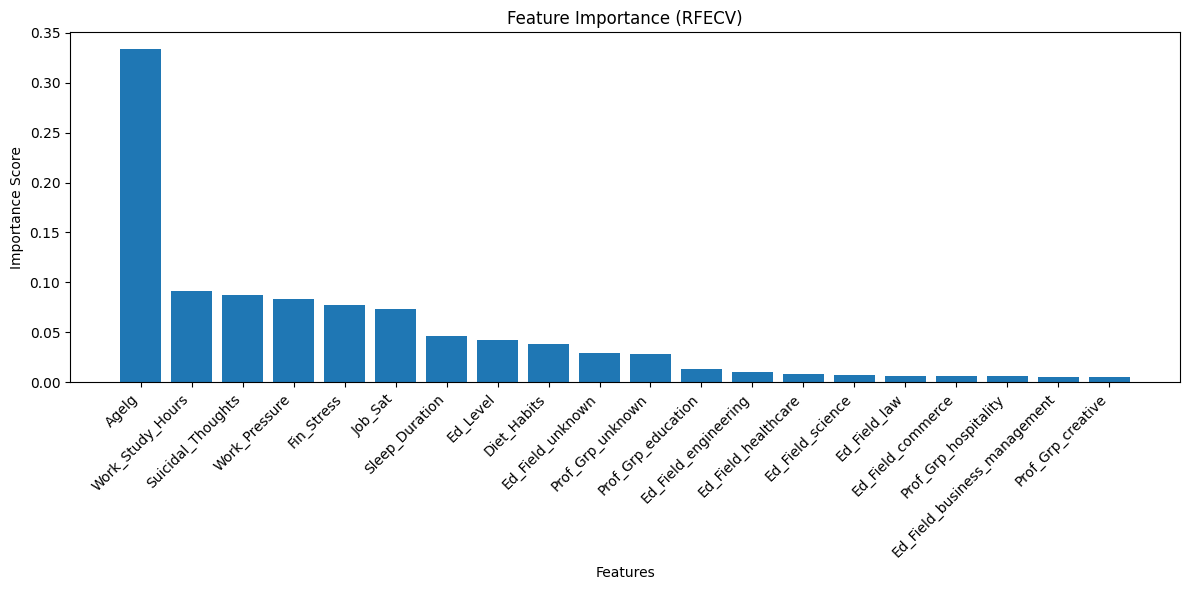

In [53]:
# Recursive Feature Elimination for feature selection

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Define your model
model = RandomForestClassifier(random_state=42)

# Initialize RFECV
rfecv = RFECV(
    estimator=model,
    step=1,  
    cv=StratifiedKFold(3),
    scoring='accuracy'
)

rfecv.fit(Xw_train, yw_train)

# Get the optimal number of features
print(f"Optimal Number of Features: {rfecv.n_features_}")

# Get the selected features and their importances
rf_selected_features = Xw_train.columns[rfecv.support_]
feature_importances = rfecv.estimator_.feature_importances_

# Create a DataFrame for sorted feature importance
importance_df = pd.DataFrame({
    'Feature': rf_selected_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the sorted feature importance
plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], align='center')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance (RFECV)')
plt.tight_layout()
plt.show()

Optimal Number of Features: 22


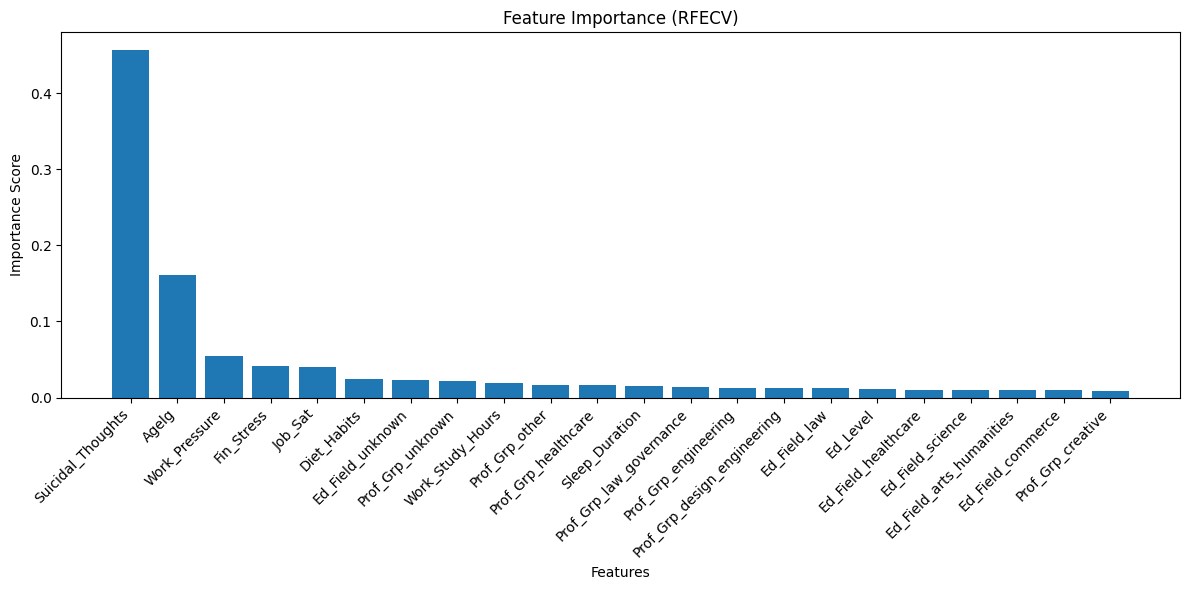

In [54]:
# Recursive Feature Elimination for feature selection
from xgboost import XGBClassifier

# Define your model
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Initialize RFECV
rfecv = RFECV(
    estimator=model,
    step=1,  
    cv=StratifiedKFold(3),
    scoring='accuracy'
)

rfecv.fit(Xw_train, yw_train)

# Get the optimal number of features
print(f"Optimal Number of Features: {rfecv.n_features_}")

# Get the selected features and their importances
xgb_selected_features = Xw_train.columns[rfecv.support_]
feature_importances = rfecv.estimator_.feature_importances_

# Create a DataFrame for sorted feature importance
importance_df = pd.DataFrame({
    'Feature': xgb_selected_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the sorted feature importance
plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], align='center')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance (RFECV)')
plt.tight_layout()
plt.show()

Optimal Number of Features: 43


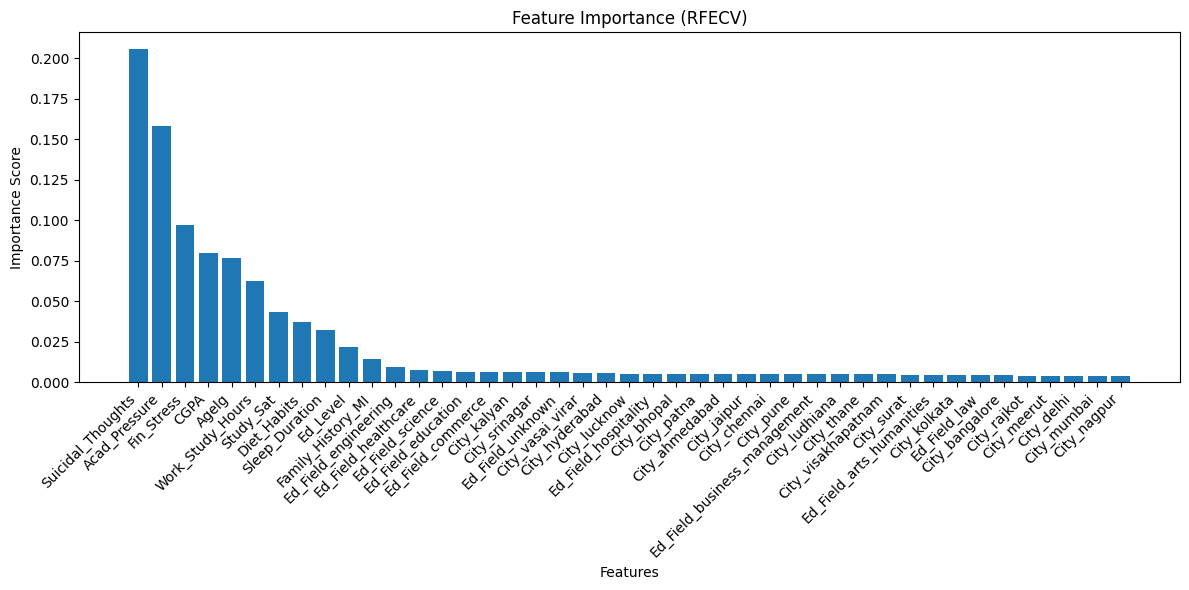

In [55]:
# Recursive Feature Elimination for feature selection

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Define your model
model = RandomForestClassifier(random_state=42)

# Initialize RFECV
rfecv = RFECV(
    estimator=model,
    step=1,  
    cv=StratifiedKFold(3),
    scoring='accuracy'
)

rfecv.fit(Xs_train, ys_train)

# Get the optimal number of features
print(f"Optimal Number of Features: {rfecv.n_features_}")

# Get the selected features and their importances
rfs_selected_features = Xs_train.columns[rfecv.support_]
feature_importances = rfecv.estimator_.feature_importances_

# Create a DataFrame for sorted feature importance
importance_df = pd.DataFrame({
    'Feature': rfs_selected_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the sorted feature importance
plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], align='center')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance (RFECV)')
plt.tight_layout()
plt.show()

Optimal Number of Features: 44


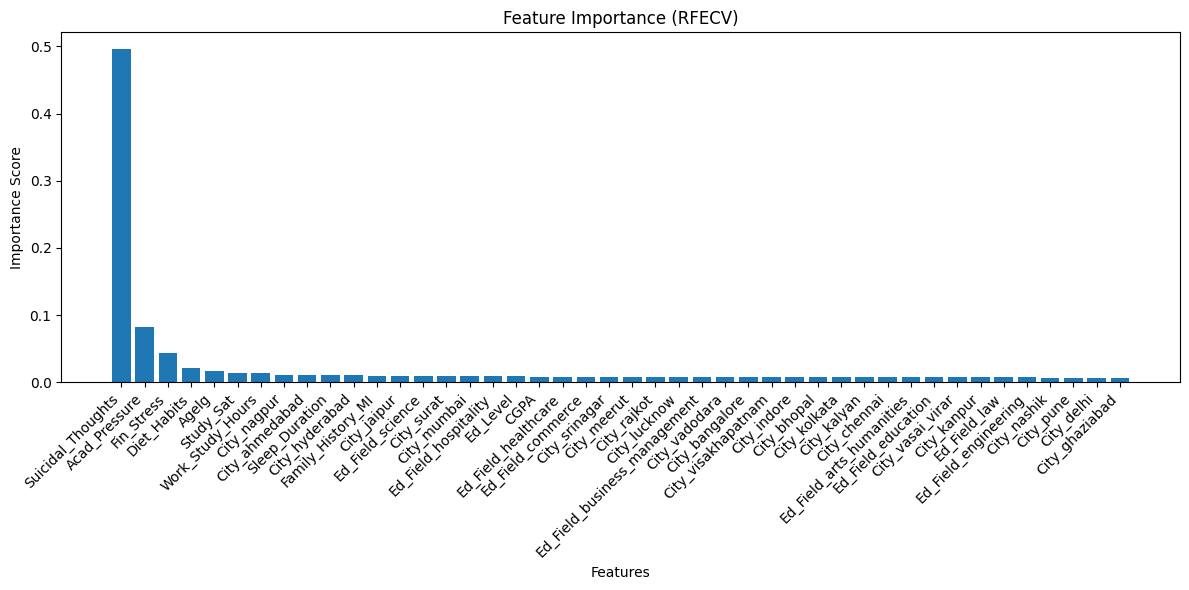

In [56]:
# Define your model
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Initialize RFECV
rfecv = RFECV(
    estimator=model,
    step=1,  
    cv=StratifiedKFold(3),
    scoring='accuracy'
)

rfecv.fit(Xs_train, ys_train)

# Get the optimal number of features
print(f"Optimal Number of Features: {rfecv.n_features_}")

# Get the selected features and their importances
xgbs_selected_features = Xs_train.columns[rfecv.support_]
feature_importances = rfecv.estimator_.feature_importances_

# Create a DataFrame for sorted feature importance
importance_df = pd.DataFrame({
    'Feature': xgbs_selected_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the sorted feature importance
plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], align='center')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance (RFECV)')
plt.tight_layout()
plt.show()

In [57]:
# Final datasets

# Working Professional
Xw_train_rfe = Xw_train[xgb_selected_features]
Xw_test_rfe = Xw_test[xgb_selected_features]
working_test_rfe = working_test_df[xgb_selected_features]

display(Xw_train_rfe.head())
display(Xw_test_rfe.head())

,Work_Pressure,Job_Sat,Sleep_Duration,Diet_Habits,Work_Study_Hours,Fin_Stress,Suicidal_Thoughts,Ed_Level,Agelg,Ed_Field_arts_humanities,Ed_Field_commerce,Ed_Field_healthcare,Ed_Field_law,Ed_Field_science,Ed_Field_unknown,Prof_Grp_creative,Prof_Grp_design_engineering,Prof_Grp_engineering,Prof_Grp_healthcare,Prof_Grp_law_governance,Prof_Grp_other,Prof_Grp_unknown
id,,,,,,,,,,,,,,,,,,,,,,
42343,0.00,0.75,1.000000,0.333333,-0.4,0.00,0,0.8,-0.735136,False,False,False,False,True,False,False,False,False,False,False,False,False
12541,0.25,0.50,0.333333,1.000000,-0.6,0.00,1,0.6,0.426635,False,False,False,False,False,False,False,False,False,False,False,False,False
14890,0.50,0.25,0.666667,1.000000,0.6,0.25,1,0.8,0.698753,False,True,False,False,False,False,False,False,False,False,False,False,False
84013,1.00,0.00,0.333333,0.333333,-0.6,0.75,1,0.6,-0.819331,False,False,False,True,False,False,False,False,False,False,False,False,False
46015,0.50,1.00,0.333333,0.666667,0.8,0.00,1,0.6,0.483020,True,False,False,False,False,False,False,False,False,False,False,False,False


,Work_Pressure,Job_Sat,Sleep_Duration,Diet_Habits,Work_Study_Hours,Fin_Stress,Suicidal_Thoughts,Ed_Level,Agelg,Ed_Field_arts_humanities,Ed_Field_commerce,Ed_Field_healthcare,Ed_Field_law,Ed_Field_science,Ed_Field_unknown,Prof_Grp_creative,Prof_Grp_design_engineering,Prof_Grp_engineering,Prof_Grp_healthcare,Prof_Grp_law_governance,Prof_Grp_other,Prof_Grp_unknown
id,,,,,,,,,,,,,,,,,,,,,,
102617,0.00,0.50,0.666667,1.000000,0.0,0.00,0,0.6,0.483020,False,True,False,False,False,False,False,False,False,False,False,False,False
28180,0.75,0.00,0.333333,0.666667,0.4,0.25,0,0.6,-0.133627,False,False,False,False,False,False,False,False,False,False,False,False,False
125522,0.50,0.50,0.000000,1.000000,-1.0,0.75,0,0.6,0.483020,False,False,False,False,False,False,True,False,False,False,False,False,False
139916,0.25,0.25,0.333333,0.333333,0.4,0.75,0,0.6,-0.819331,False,False,False,False,False,False,False,False,False,False,False,False,False
26630,0.75,1.00,1.000000,0.333333,0.6,1.00,0,0.6,-0.273329,False,False,True,False,False,False,False,False,False,True,False,False,False


In [58]:
# Student
Xs_train_rfe = Xs_train[xgbs_selected_features]
Xs_test_rfe = Xs_test[xgbs_selected_features]
student_test_rfe = student_test_df[xgbs_selected_features]

Xs_train_rfe.head()

,Acad_Pressure,CGPA,Study_Sat,Sleep_Duration,Diet_Habits,Work_Study_Hours,Fin_Stress,Suicidal_Thoughts,Family_History_MI,Ed_Level,Agelg,Ed_Field_arts_humanities,Ed_Field_business_management,Ed_Field_commerce,Ed_Field_education,Ed_Field_engineering,Ed_Field_healthcare,Ed_Field_hospitality,Ed_Field_law,Ed_Field_science,City_ahmedabad,City_bangalore,City_bhopal,City_chennai,City_delhi,City_ghaziabad,City_hyderabad,City_indore,City_jaipur,City_kalyan,City_kanpur,City_kolkata,City_lucknow,City_meerut,City_mumbai,City_nagpur,City_nashik,City_pune,City_rajkot,City_srinagar,City_surat,City_vadodara,City_vasai_virar,City_visakhapatnam
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8551,0.75,-0.665399,0.00,0.000000,0.666667,-1.0,1.0,1,0,1,-1.024649,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
125925,0.50,-0.532319,0.25,0.000000,0.666667,0.2,0.0,0,1,2,-0.110048,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
139260,0.50,0.558935,0.25,0.000000,0.333333,-0.6,1.0,1,1,3,0.402836,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
68491,0.50,-0.152091,1.00,0.000000,0.666667,0.8,0.5,1,0,2,0.756714,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
136261,0.50,-0.114068,0.75,0.666667,0.333333,0.6,1.0,0,0,2,-0.110048,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


# **Model Building**
---

In [59]:
import itertools
from matplotlib.cbook import boxplot_stats
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fowlkes_mallows_score, matthews_corrcoef, roc_auc_score, roc_curve, precision_recall_curve, make_scorer, classification_report

In [60]:
def model_cross_validation_perf(clfs, X, y):
    print(f"\nCross-Validation Performance:\n")
    results = []
    names = []

    for name, clf in clfs:
        # Preprocess data only for logistic regression models
        if isinstance(clf, (LogisticRegression, LogisticRegressionCV)):
            X_preprocessed = sm.add_constant(X, has_constant="add")
        else:
            X_preprocessed = X

        # Stratified K-Fold cross-validation
        kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        
        try:
            # Perform cross-validation
            cv_scores = cross_val_score(
                estimator=clf, X=X_preprocessed, y=y, scoring="accuracy", cv=kfold
            )
            results.append(cv_scores)
            names.append(name)
            print(f"{name}: Mean Score = {cv_scores.mean():.4f}, Std Dev = {cv_scores.std():.4f}")
        except ValueError as e:
            print(f"Error for classifier {name}: {e}")
    
    # Compile results
    cv_results = pd.DataFrame({
        "Classifier": names,
        "Mean Score": [np.mean(result) for result in results],
        "Std Deviation": [np.std(result) for result in results]
    })
    
    # Highlight best and worst classifiers
    styled_results = (cv_results.style
                      .highlight_max(subset=["Mean Score"], props="background-color: lightgreen; font-weight: bold")
                      .highlight_min(subset=["Mean Score"], props="background-color: lightcoral; font-weight: bold")
                      .highlight_max(subset=["Std Deviation"], props="background-color: lightcoral; font-weight: bold")
                      .highlight_min(subset=["Std Deviation"], props="background-color: lightgreen; font-weight: bold"))
    
    display(styled_results)
    return results, names

In [61]:
# Define a function to generate boxplots to compare models" performance
def boxplot_cv(results, names):
    fig, ax = plt.subplots(figsize=(18, 6))

    bp = ax.boxplot(results, patch_artist=True, widths=0.5,
                    meanline=True, showmeans=True)

    for patch in bp["boxes"]:
        patch.set_facecolor("skyblue")
        patch.set_edgecolor("black")

    for median in bp["medians"]:
        median.set_color("black")
        median.set_linewidth(2)

    for whisker in bp["whiskers"]:
        whisker.set_color("black")
        whisker.set_linewidth(2)

    for cap in bp["caps"]:
        cap.set_color("black")
        cap.set_linewidth(2)

    # Add mean lines for each boxplot
    for i, line in enumerate(bp['means']):
        x, y = line.get_xydata()[1]
        plt.text(x+0.01, y, f'{np.mean(results[i]):.2f}',
                 verticalalignment='center', color='navy', fontsize=14, fontweight=700)

    ax.set_title("Classifier Comparison", fontsize=18, fontweight=700)
    ax.set_xlabel("\nAlgorithm", fontsize=14)
    ax.set_ylabel("Score\n", fontsize=14)
    ax.yaxis.grid(True, linestyle="-", linewidth=0.5)
    ax.set_xticklabels(names, rotation=90)
    ax.set_facecolor("white")
    ax.spines[["top", "right"]].set_visible(False)
    ax.spines[["left", "bottom"]].set_color("black")

    plt.show()

In [62]:
def find_optimal_threshold(clf, X_test, y_test, metric="accuracy", step=0.01):
    """
    Finds the optimal threshold for a classifier based on a specified metric.
    """
    try:
        y_probs = clf.predict_proba(X_test)[:, 1]
    except AttributeError:
        raise AttributeError(f"The classifier '{clf}' does not support `predict_proba`.")

    thresholds = np.arange(0, 1 + step, step)
    scores = []

    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        if metric == "accuracy":
            scores.append(accuracy_score(y_test, y_pred))
        elif metric == "f1":
            scores.append(f1_score(y_test, y_pred, zero_division=0))
        else:
            raise ValueError(f"Unsupported metric '{metric}' for threshold optimization.")

    optimal_idx = np.argmax(scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

In [63]:
def get_metrics_scores(clf, X, y, threshold):
    """
    Compute evaluation metrics for a classifier at a specific threshold.
    """
    try:
        y_probs = clf.predict_proba(X)[:, 1]
    except AttributeError:
        raise AttributeError(f"The classifier '{clf}' does not support `predict_proba`.")

    y_pred = (y_probs >= threshold).astype(int)

    metrics = {
        "Threshold": threshold,
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred, zero_division=0),
        "Recall": recall_score(y, y_pred, zero_division=0),
        "F1": f1_score(y, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y, y_probs),
        "MCC": matthews_corrcoef(y, y_pred),
        "FMI": fowlkes_mallows_score(y, y_pred)
    }
    return metrics

In [64]:
def model_perf(clfs, Xfit, yfit, X, y, threshold_optimization="accuracy"):
    """
    Evaluate classifiers with dynamic thresholds and return/display results after each algorithm.
    """
    all_results = {}

    for name, clf in clfs:
        print(f"\nRunning evaluation for classifier: {name}")

        # Fit the classifier
        try:
            clf.fit(Xfit, yfit)
        except Exception as e:
            print(f"Error fitting classifier '{name}': {e}")
            continue

        # Find optimal threshold based on the specified optimization criterion
        try:
            optimal_threshold = find_optimal_threshold(clf, X, y, metric=threshold_optimization)
        except Exception as e:
            print(f"Error finding optimal threshold for '{name}': {e}")
            continue

        # Collect metrics
        try:
            train_metrics = get_metrics_scores(clf, Xfit, yfit, threshold=optimal_threshold)
            train_metrics["Dataset"] = "Train"
            test_metrics = get_metrics_scores(clf, X, y, threshold=optimal_threshold)
            test_metrics["Dataset"] = "Test"
        except Exception as e:
            print(f"Error calculating metrics for '{name}': {e}")
            continue

        # Combine results
        combined_metrics = pd.DataFrame([train_metrics, test_metrics])
        combined_metrics.insert(0, "Classifier", name)
        

        # Display results for this classifier
        display(combined_metrics)

        # Store results
        all_results[name] = {
            "optimal_threshold": optimal_threshold,
            "metrics": combined_metrics
        }

    return all_results

In [65]:
# Define class imbalance ratio 
positive_class_count = yw_train.sum()
negative_class_count = len(yw_train) - positive_class_count
imbalance_ratio = negative_class_count / positive_class_count
print(f"Imbalanced ratio: {imbalance_ratio}")

Imbalanced ratio: 11.219228165199729


In [66]:
# Define classifiers
wclassifiers = [
    # Linear Models
    ("Logistic Regression (newton-cg)", LogisticRegression(solver="newton-cg", class_weight="balanced", random_state=42)),
    ("Logistic Regression (liblinear)", LogisticRegression(solver="liblinear", class_weight="balanced", random_state=42)),
    ("Logistic Regression (sag)", LogisticRegression(solver="sag", class_weight="balanced", random_state=42)),
    ("Logistic Regression (saga)", LogisticRegression(solver="saga", class_weight="balanced", random_state=42)),
    ("Logistic Regression (lbfgs)", LogisticRegression(solver="lbfgs", class_weight="balanced", random_state=42)),

    # Tree-Based Models
    ("Decision Trees", DecisionTreeClassifier(class_weight="balanced", random_state=42)),
    ("Random forest", RandomForestClassifier(class_weight="balanced", random_state=42)),
    ("Extra Trees", ExtraTreesClassifier(class_weight="balanced", random_state=42)),

    # Boosting Methods
    ("Adaboost", AdaBoostClassifier(random_state=42)),
    ("GBM", GradientBoostingClassifier(random_state=42)),
    ("XGboost", XGBClassifier(scale_pos_weight=imbalance_ratio, random_state=42, eval_metric="logloss")),
    ("CatBoost", CatBoostClassifier(auto_class_weights="Balanced", silent=True, random_state=42)),
    ("LightGBM", LGBMClassifier(class_weight="balanced", verbosity=0, random_state=42)),

    # Nearest Neighbor Models
    ("K-Nearest Neighbors", KNeighborsClassifier()),  

    # Naive Bayes Models
    ("Gaussian Naive Bayes", GaussianNB()),  
    ("Bernoulli Naive Bayes", BernoulliNB())
]

In [67]:
# Define classifiers
sclassifiers = [
    # Linear Models
    ("Logistic Regression (newton-cg)", LogisticRegression(solver="newton-cg", random_state=42)),
    ("Logistic Regression (liblinear)", LogisticRegression(solver="liblinear", random_state=42)),
    ("Logistic Regression (sag)", LogisticRegression(solver="sag", random_state=42)),
    ("Logistic Regression (saga)", LogisticRegression(solver="saga", random_state=42)),
    ("Logistic Regression (lbfgs)", LogisticRegression(solver="lbfgs", random_state=42)),

    # Tree-Based Models
    ("Decision Trees", DecisionTreeClassifier(random_state=42)),
    ("Random forest", RandomForestClassifier(random_state=42)),
    ("Extra Trees", ExtraTreesClassifier(random_state=42)),

    # Boosting Methods
    ("Adaboost", AdaBoostClassifier(random_state=42)),
    ("GBM", GradientBoostingClassifier(random_state=42)),
    ("XGboost", XGBClassifier(random_state=42, eval_metric="logloss")),
    ("CatBoost", CatBoostClassifier(silent=True, random_state=42)),
    ("LightGBM", LGBMClassifier(verbosity=0, random_state=42)),

    # Nearest Neighbor Models
    ("K-Nearest Neighbors", KNeighborsClassifier()),  

    # Naive Bayes Models
    ("Gaussian Naive Bayes", GaussianNB()),  
    ("Bernoulli Naive Bayes", BernoulliNB())
]

# **Model Training, Cross Validation and Performance Evaluation**
---


Cross-Validation Performance:

Logistic Regression (newton-cg): Mean Score = 0.9121, Std Dev = 0.0016
Logistic Regression (liblinear): Mean Score = 0.9121, Std Dev = 0.0017
Logistic Regression (sag): Mean Score = 0.9121, Std Dev = 0.0016
Logistic Regression (saga): Mean Score = 0.9121, Std Dev = 0.0016
Logistic Regression (lbfgs): Mean Score = 0.9121, Std Dev = 0.0016
Decision Trees: Mean Score = 0.9386, Std Dev = 0.0012
Random forest: Mean Score = 0.9582, Std Dev = 0.0002
Extra Trees: Mean Score = 0.9568, Std Dev = 0.0011
Adaboost: Mean Score = 0.9609, Std Dev = 0.0000
GBM: Mean Score = 0.9611, Std Dev = 0.0001
XGboost: Mean Score = 0.9342, Std Dev = 0.0010
CatBoost: Mean Score = 0.9333, Std Dev = 0.0009
LightGBM: Mean Score = 0.9229, Std Dev = 0.0016
K-Nearest Neighbors: Mean Score = 0.9552, Std Dev = 0.0008
Gaussian Naive Bayes: Mean Score = 0.9142, Std Dev = 0.0024
Bernoulli Naive Bayes: Mean Score = 0.9214, Std Dev = 0.0013


,Classifier,Mean Score,Std Deviation
0,Logistic Regression (newton-cg),0.912122,0.001644
1,Logistic Regression (liblinear),0.912111,0.001658
2,Logistic Regression (sag),0.912122,0.001644
3,Logistic Regression (saga),0.912122,0.001644
4,Logistic Regression (lbfgs),0.912111,0.001643
5,Decision Trees,0.938607,0.001228
6,Random forest,0.958233,0.000177
7,Extra Trees,0.956759,0.001091
8,Adaboost,0.960937,0.000046
9,GBM,0.961081,0.000113


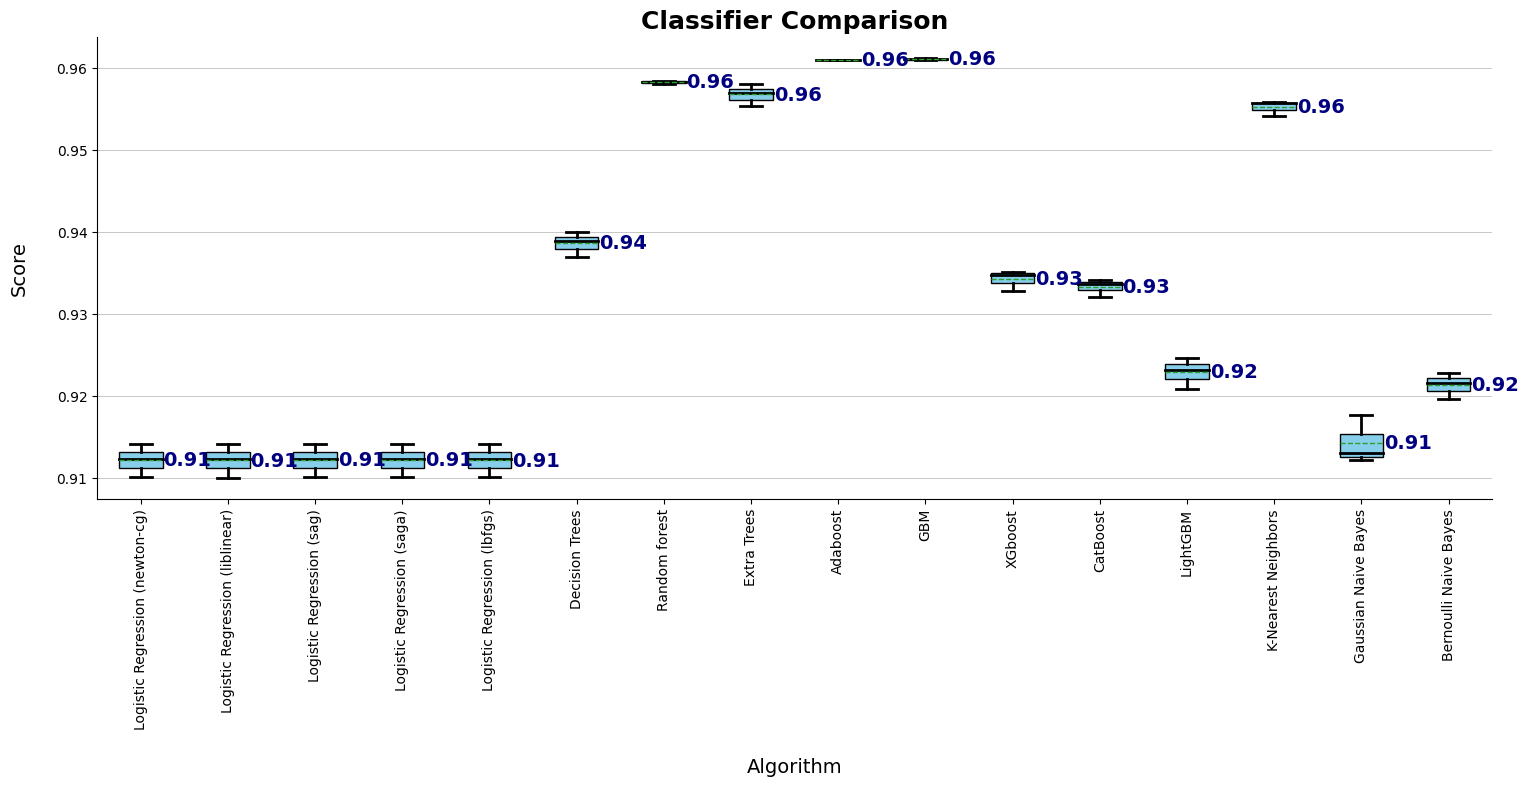


Running evaluation for classifier: Logistic Regression (newton-cg)


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Logistic Regression (newton-cg),0.91,0.959242,0.794347,0.677319,0.731180,0.968938,0.711917,0.954602,Train
1,Logistic Regression (newton-cg),0.91,0.958067,0.780549,0.678223,0.725797,0.967508,0.705251,0.953273,Test



Running evaluation for classifier: Logistic Regression (liblinear)


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Logistic Regression (liblinear),0.91,0.959242,0.794627,0.676913,0.731062,0.968937,0.711833,0.954606,Train
1,Logistic Regression (liblinear),0.91,0.958023,0.780412,0.677681,0.725428,0.967503,0.704876,0.953228,Test



Running evaluation for classifier: Logistic Regression (sag)


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Logistic Regression (sag),0.91,0.959242,0.794347,0.677319,0.731180,0.968938,0.711917,0.954602,Train
1,Logistic Regression (sag),0.91,0.958067,0.780549,0.678223,0.725797,0.967509,0.705251,0.953273,Test



Running evaluation for classifier: Logistic Regression (saga)


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Logistic Regression (saga),0.91,0.959242,0.794347,0.677319,0.731180,0.968938,0.711917,0.954602,Train
1,Logistic Regression (saga),0.91,0.958067,0.780549,0.678223,0.725797,0.967508,0.705251,0.953273,Test



Running evaluation for classifier: Logistic Regression (lbfgs)


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Logistic Regression (lbfgs),0.91,0.959253,0.794473,0.677319,0.731233,0.968938,0.711982,0.954615,Train
1,Logistic Regression (lbfgs),0.91,0.958067,0.780549,0.678223,0.725797,0.967508,0.705251,0.953273,Test



Running evaluation for classifier: Decision Trees


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Decision Trees,0.92,0.999623,1.000000,0.995396,0.997693,0.999999,0.997491,0.999557,Train
1,Decision Trees,0.92,0.936879,0.614549,0.613218,0.613883,0.789686,0.579514,0.930415,Test



Running evaluation for classifier: Random forest


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Random forest,0.5,0.999601,0.995282,0.999865,0.997568,0.999961,0.997354,0.999531,Train
1,Random forest,0.5,0.957668,0.798392,0.645720,0.713986,0.961932,0.695947,0.953140,Test



Running evaluation for classifier: Extra Trees


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Extra Trees,0.47,0.999612,0.995283,1.000000,0.997636,0.999999,0.997428,0.999544,Train
1,Extra Trees,0.47,0.955851,0.779605,0.641928,0.704100,0.955217,0.684239,0.951140,Test



Running evaluation for classifier: Adaboost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Adaboost,0.5,0.961037,0.810763,0.683412,0.741661,0.970210,0.723834,0.956568,Train
1,Adaboost,0.5,0.959796,0.792523,0.689057,0.737178,0.968132,0.717579,0.955118,Test



Running evaluation for classifier: GBM


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,GBM,0.55,0.961070,0.842534,0.644821,0.730536,0.972132,0.717336,0.956975,Train
1,GBM,0.55,0.960106,0.824863,0.650596,0.727438,0.969108,0.712032,0.955831,Test



Running evaluation for classifier: XGboost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,XGboost,0.92,0.967542,0.863458,0.716723,0.783278,0.989691,0.769781,0.963639,Train
1,XGboost,0.92,0.958777,0.797789,0.664680,0.725177,0.964654,0.706518,0.954198,Test



Running evaluation for classifier: CatBoost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,CatBoost,0.91,0.967254,0.856683,0.720379,0.782641,0.988774,0.768437,0.963282,Train
1,CatBoost,0.91,0.959663,0.799616,0.676598,0.732981,0.966513,0.714233,0.955082,Test



Running evaluation for classifier: LightGBM


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,LightGBM,0.92,0.963552,0.833225,0.693433,0.756929,0.981335,0.741041,0.959317,Train
1,LightGBM,0.92,0.959574,0.796696,0.679307,0.733333,0.969262,0.714259,0.954957,Test



Running evaluation for classifier: K-Nearest Neighbors


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,K-Nearest Neighbors,0.41,0.966290,0.842130,0.723764,0.778474,0.987450,0.762898,0.962161,Train
1,K-Nearest Neighbors,0.41,0.954832,0.759899,0.654930,0.703521,0.913458,0.681419,0.949868,Test



Running evaluation for classifier: Gaussian Naive Bayes


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Gaussian Naive Bayes,1.0,0.918162,0.0,0.0,0.0,0.902207,0.0,0.921801,Train
1,Gaussian Naive Bayes,1.0,0.918174,0.0,0.0,0.0,0.900611,0.0,0.921809,Test



Running evaluation for classifier: Bernoulli Naive Bayes


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Bernoulli Naive Bayes,0.93,0.931925,0.745843,0.255112,0.380184,0.915101,0.411072,0.930653,Train
1,Bernoulli Naive Bayes,0.93,0.931959,0.738132,0.261105,0.385754,0.910829,0.413392,0.930566,Test


In [68]:
# Perform Cross Validation on Working Professional Dataset
cvw_results, cvw_names = model_cross_validation_perf(wclassifiers, Xw_train_rfe, yw_train)
boxplot_cv(cvw_results, cvw_names)

# Model evaluation 
wresults = model_perf(wclassifiers, Xw_train_rfe, yw_train, Xw_test_rfe, yw_test, threshold_optimization="accuracy")


Cross-Validation Performance:

Logistic Regression (newton-cg): Mean Score = 0.8472, Std Dev = 0.0018
Logistic Regression (liblinear): Mean Score = 0.8471, Std Dev = 0.0017
Logistic Regression (sag): Mean Score = 0.8472, Std Dev = 0.0018
Logistic Regression (saga): Mean Score = 0.8473, Std Dev = 0.0018
Logistic Regression (lbfgs): Mean Score = 0.8472, Std Dev = 0.0018
Decision Trees: Mean Score = 0.7704, Std Dev = 0.0037
Random forest: Mean Score = 0.8423, Std Dev = 0.0020
Extra Trees: Mean Score = 0.8377, Std Dev = 0.0009
Adaboost: Mean Score = 0.8481, Std Dev = 0.0023
GBM: Mean Score = 0.8447, Std Dev = 0.0012
XGboost: Mean Score = 0.8351, Std Dev = 0.0035
CatBoost: Mean Score = 0.8457, Std Dev = 0.0032
LightGBM: Mean Score = 0.8431, Std Dev = 0.0002
K-Nearest Neighbors: Mean Score = 0.7921, Std Dev = 0.0029
Gaussian Naive Bayes: Mean Score = 0.7767, Std Dev = 0.0051
Bernoulli Naive Bayes: Mean Score = 0.8100, Std Dev = 0.0035


,Classifier,Mean Score,Std Deviation
0,Logistic Regression (newton-cg),0.847222,0.001788
1,Logistic Regression (liblinear),0.847133,0.001680
2,Logistic Regression (sag),0.847222,0.001788
3,Logistic Regression (saga),0.847267,0.001750
4,Logistic Regression (lbfgs),0.847222,0.001788
5,Decision Trees,0.770430,0.003666
6,Random forest,0.842294,0.001995
7,Extra Trees,0.837724,0.000933
8,Adaboost,0.848073,0.002277
9,GBM,0.844713,0.001209


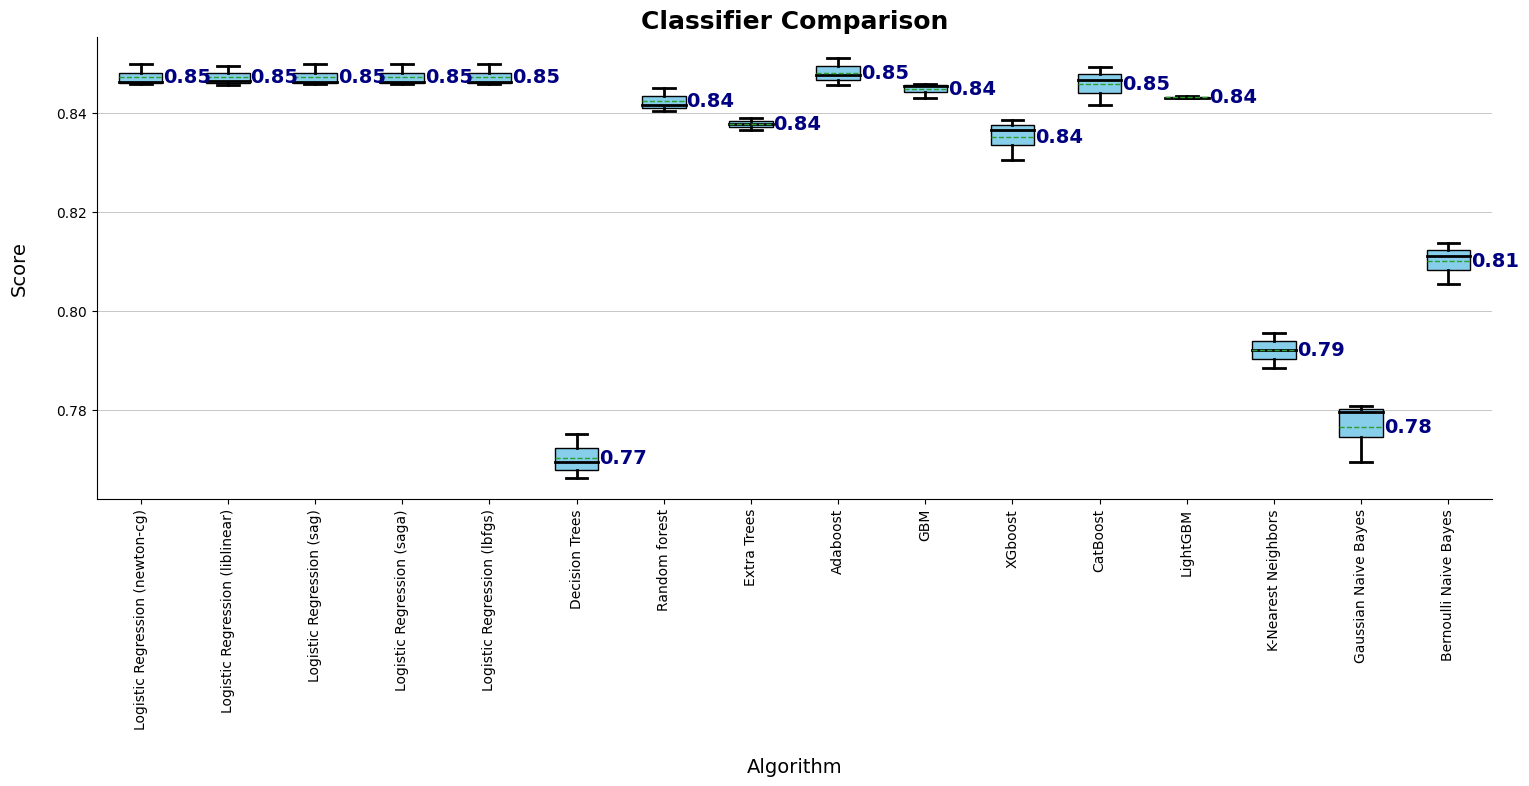


Running evaluation for classifier: Logistic Regression (newton-cg)


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Logistic Regression (newton-cg),0.5,0.846819,0.856868,0.886440,0.871403,0.920342,0.682752,0.749812,Train
1,Logistic Regression (newton-cg),0.5,0.842143,0.854681,0.880049,0.867179,0.916539,0.673195,0.743247,Test



Running evaluation for classifier: Logistic Regression (liblinear)


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Logistic Regression (liblinear),0.5,0.846729,0.856847,0.886287,0.871318,0.920345,0.682570,0.749683,Train
1,Logistic Regression (liblinear),0.5,0.842681,0.855021,0.880661,0.867651,0.916536,0.674298,0.743977,Test



Running evaluation for classifier: Logistic Regression (sag)


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Logistic Regression (sag),0.5,0.846774,0.856805,0.886440,0.871371,0.920342,0.682656,0.749757,Train
1,Logistic Regression (sag),0.5,0.842143,0.854681,0.880049,0.867179,0.916540,0.673195,0.743247,Test



Running evaluation for classifier: Logistic Regression (saga)


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Logistic Regression (saga),0.5,0.846819,0.856868,0.886440,0.871403,0.920342,0.682752,0.749812,Train
1,Logistic Regression (saga),0.5,0.842143,0.854681,0.880049,0.867179,0.916540,0.673195,0.743247,Test



Running evaluation for classifier: Logistic Regression (lbfgs)


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Logistic Regression (lbfgs),0.5,0.846819,0.856868,0.886440,0.871403,0.920342,0.682752,0.749812,Train
1,Logistic Regression (lbfgs),0.5,0.842143,0.854681,0.880049,0.867179,0.916536,0.673195,0.743247,Test



Running evaluation for classifier: Decision Trees


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Decision Trees,0.01,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,Train
1,Decision Trees,0.01,0.768321,0.799697,0.806304,0.802986,0.76048,0.521876,0.654572,Test



Running evaluation for classifier: Random forest


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Random forest,0.56,0.999955,1.000000,0.999923,0.999962,1.000000,0.999908,0.999913,Train
1,Random forest,0.56,0.838739,0.869308,0.852815,0.860982,0.913281,0.669219,0.736184,Test



Running evaluation for classifier: Extra Trees


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Extra Trees,0.52,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Extra Trees,0.52,0.83623,0.848431,0.876989,0.862474,0.908378,0.660772,0.735752,Test



Running evaluation for classifier: Adaboost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Adaboost,0.5,0.849418,0.858748,0.889042,0.873632,0.922074,0.688126,0.753348,Train
1,Adaboost,0.5,0.842143,0.855526,0.878825,0.867019,0.917252,0.673292,0.743099,Test



Running evaluation for classifier: GBM


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,GBM,0.5,0.851434,0.859852,0.891567,0.875423,0.926121,0.692271,0.756170,Train
1,GBM,0.5,0.846085,0.855415,0.887087,0.870963,0.918115,0.681132,0.748935,Test



Running evaluation for classifier: XGboost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,XGboost,0.45,0.915009,0.906189,0.953551,0.929267,0.974277,0.824668,0.850719,Train
1,XGboost,0.45,0.835513,0.838617,0.890453,0.863758,0.910057,0.658605,0.736781,Test



Running evaluation for classifier: CatBoost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,CatBoost,0.55,0.888844,0.905974,0.903964,0.904968,0.956057,0.771102,0.807912,Train
1,CatBoost,0.55,0.846622,0.870621,0.866891,0.868752,0.917721,0.684280,0.747387,Test



Running evaluation for classifier: LightGBM


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,LightGBM,0.51,0.871550,0.881517,0.901821,0.891554,0.945084,0.734388,0.783495,Train
1,LightGBM,0.51,0.842143,0.859163,0.873623,0.866333,0.917151,0.673769,0.742494,Test



Running evaluation for classifier: K-Nearest Neighbors


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,K-Nearest Neighbors,0.41,0.858289,0.854992,0.912764,0.882934,0.934971,0.706334,0.767492,Train
1,K-Nearest Neighbors,0.41,0.790719,0.795276,0.865361,0.828839,0.848717,0.564139,0.685530,Test



Running evaluation for classifier: Gaussian Naive Bayes


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Gaussian Naive Bayes,0.47,0.789337,0.825627,0.811601,0.818554,0.858621,0.567621,0.675843,Train
1,Gaussian Naive Bayes,0.47,0.786060,0.825078,0.805386,0.815113,0.857270,0.561605,0.671720,Test



Running evaluation for classifier: Bernoulli Naive Bayes


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Bernoulli Naive Bayes,0.51,0.810573,0.830393,0.850092,0.840127,0.878323,0.608073,0.703097,Train
1,Bernoulli Naive Bayes,0.51,0.809532,0.835005,0.840881,0.837933,0.872973,0.607025,0.700710,Test


In [69]:
# Perform Cross Validation on Student Dataset
cvs_results, cvs_names = model_cross_validation_perf(sclassifiers, Xs_train_rfe, ys_train)
boxplot_cv(cvs_results, cvs_names)

# Model evaluation 
sresults = model_perf(sclassifiers, Xs_train_rfe, ys_train, Xs_test_rfe, ys_test, threshold_optimization="accuracy")

In [70]:
from imblearn.combine import SMOTEENN
from collections import Counter

# Instantiate SMOTEENN
smote_enn = SMOTEENN(random_state=42)

# Apply SMOTEENN to the training dataset
Xw_train_sm_rfe, yw_train_sm = smote_enn.fit_resample(Xw_train_rfe, yw_train)

# Display the class distribution before and after resampling
print("Before resampling:", Counter(yw_train))
print("After resampling:", Counter(yw_train_sm))

Before resampling: Counter({0: 82854, 1: 7385})
After resampling: Counter({1: 82066, 0: 73959})



Cross-Validation Performance:

Logistic Regression (newton-cg): Mean Score = 0.9470, Std Dev = 0.0006
Logistic Regression (liblinear): Mean Score = 0.9470, Std Dev = 0.0006
Logistic Regression (sag): Mean Score = 0.9470, Std Dev = 0.0006
Logistic Regression (saga): Mean Score = 0.9470, Std Dev = 0.0006
Logistic Regression (lbfgs): Mean Score = 0.9470, Std Dev = 0.0006
Decision Trees: Mean Score = 0.9783, Std Dev = 0.0007
Random forest: Mean Score = 0.9910, Std Dev = 0.0006
Extra Trees: Mean Score = 0.9946, Std Dev = 0.0003
Adaboost: Mean Score = 0.9748, Std Dev = 0.0009
GBM: Mean Score = 0.9839, Std Dev = 0.0002
XGboost: Mean Score = 0.9900, Std Dev = 0.0006
CatBoost: Mean Score = 0.9902, Std Dev = 0.0008
LightGBM: Mean Score = 0.9891, Std Dev = 0.0005
K-Nearest Neighbors: Mean Score = 0.9860, Std Dev = 0.0004
Gaussian Naive Bayes: Mean Score = 0.8790, Std Dev = 0.0011
Bernoulli Naive Bayes: Mean Score = 0.8810, Std Dev = 0.0013


,Classifier,Mean Score,Std Deviation
0,Logistic Regression (newton-cg),0.946996,0.000567
1,Logistic Regression (liblinear),0.947002,0.000595
2,Logistic Regression (sag),0.946996,0.000567
3,Logistic Regression (saga),0.946996,0.000567
4,Logistic Regression (lbfgs),0.947008,0.000558
5,Decision Trees,0.978318,0.000704
6,Random forest,0.990982,0.000582
7,Extra Trees,0.994623,0.000281
8,Adaboost,0.974812,0.000879
9,GBM,0.983868,0.000231


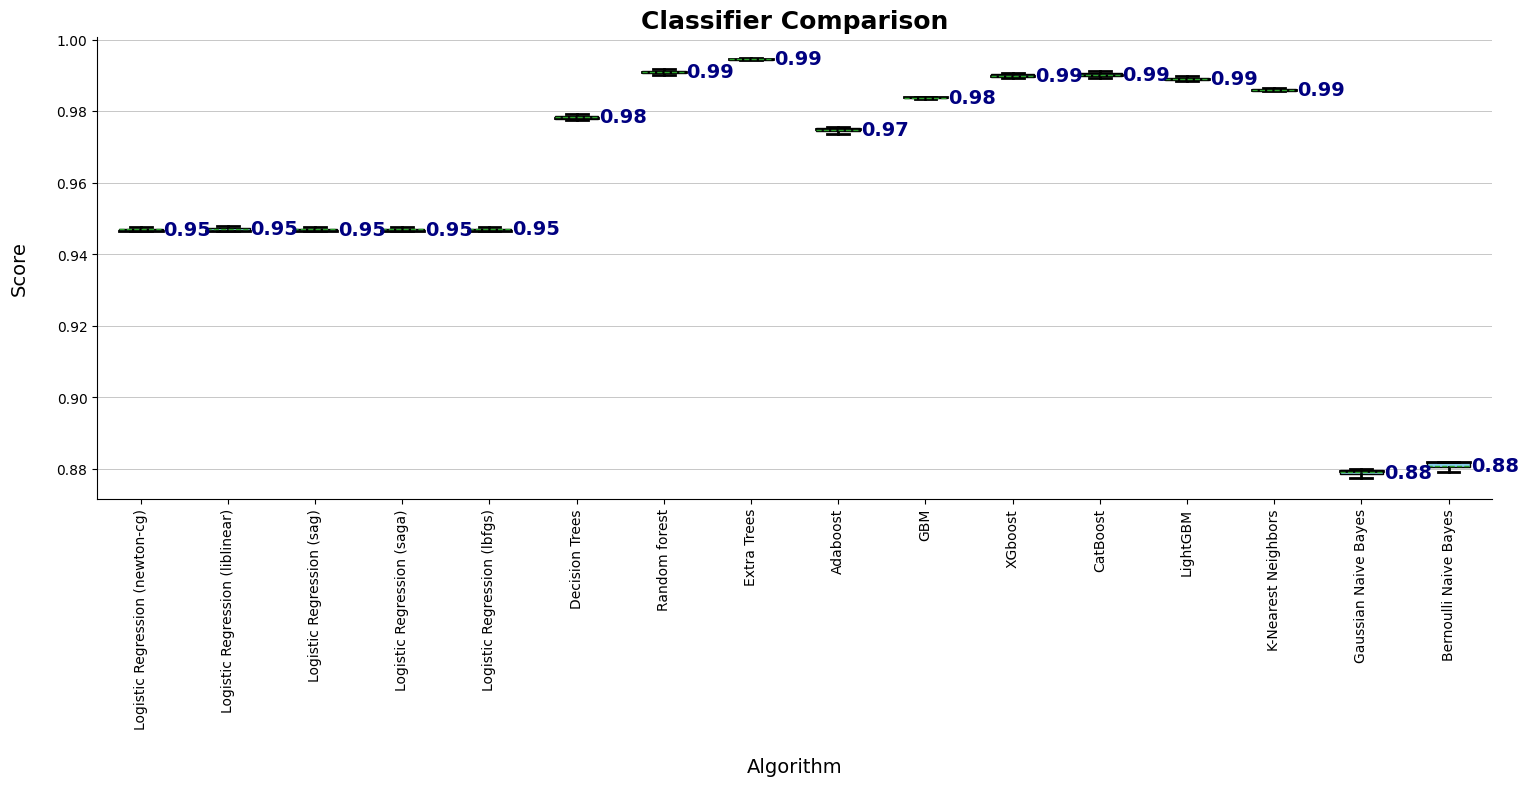


Running evaluation for classifier: Logistic Regression (newton-cg)


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Logistic Regression (newton-cg),0.98,0.841275,0.998590,0.699218,0.822510,0.988137,0.722703,0.742610,Train
1,Logistic Regression (newton-cg),0.98,0.957535,0.774752,0.678223,0.723281,0.967049,0.702213,0.952675,Test



Running evaluation for classifier: Logistic Regression (liblinear)


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Logistic Regression (liblinear),0.98,0.841096,0.998590,0.698877,0.822274,0.988137,0.722423,0.742399,Train
1,Logistic Regression (liblinear),0.98,0.957491,0.774613,0.677681,0.722912,0.967045,0.701838,0.952631,Test



Running evaluation for classifier: Logistic Regression (sag)


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Logistic Regression (sag),0.98,0.841275,0.998590,0.699218,0.822510,0.988137,0.722703,0.742610,Train
1,Logistic Regression (sag),0.98,0.957535,0.774752,0.678223,0.723281,0.967049,0.702213,0.952675,Test



Running evaluation for classifier: Logistic Regression (saga)


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Logistic Regression (saga),0.98,0.841275,0.998590,0.699218,0.822510,0.988137,0.722703,0.742610,Train
1,Logistic Regression (saga),0.98,0.957535,0.774752,0.678223,0.723281,0.967049,0.702213,0.952675,Test



Running evaluation for classifier: Logistic Regression (lbfgs)


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Logistic Regression (lbfgs),0.98,0.841275,0.998590,0.699218,0.822510,0.988137,0.722703,0.742610,Train
1,Logistic Regression (lbfgs),0.98,0.957535,0.774752,0.678223,0.723281,0.967049,0.702213,0.952675,Test



Running evaluation for classifier: Decision Trees


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Decision Trees,0.01,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Decision Trees,0.01,0.92695,0.534615,0.828277,0.649809,0.882011,0.629415,0.917703,Test



Running evaluation for classifier: Random forest


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Random forest,0.82,0.994136,1.000000,0.988850,0.994394,1.000000,0.988315,0.988365,Train
1,Random forest,0.82,0.958378,0.780805,0.683099,0.728691,0.965062,0.708111,0.953577,Test



Running evaluation for classifier: Extra Trees


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Extra Trees,0.8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Extra Trees,0.8,0.957846,0.773032,0.686349,0.727116,0.962201,0.705825,0.952949,Test



Running evaluation for classifier: Adaboost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Adaboost,0.52,0.918500,0.999669,0.845332,0.916045,0.996869,0.849074,0.85140,Train
1,Adaboost,0.52,0.957934,0.830508,0.610509,0.703715,0.967536,0.691003,0.95381,Test



Running evaluation for classifier: GBM


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,GBM,0.87,0.960602,0.999395,0.925657,0.961114,0.998331,0.924090,0.924436,Train
1,GBM,0.87,0.958422,0.777846,0.688516,0.730460,0.968222,0.709571,0.953577,Test



Running evaluation for classifier: XGboost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,XGboost,0.94,0.984829,0.999937,0.971218,0.985369,0.999617,0.970068,0.970167,Train
1,XGboost,0.94,0.959397,0.778443,0.704225,0.739477,0.967488,0.718579,0.954536,Test



Running evaluation for classifier: CatBoost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,CatBoost,0.96,0.983099,0.999987,0.967880,0.983672,0.999732,0.966718,0.966820,Train
1,CatBoost,0.96,0.960106,0.807943,0.672264,0.733885,0.967560,0.716037,0.955622,Test



Running evaluation for classifier: LightGBM


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,LightGBM,0.93,0.978817,0.999848,0.959874,0.979453,0.999175,0.958462,0.958591,Train
1,LightGBM,0.93,0.958998,0.789805,0.679848,0.730713,0.968508,0.710991,0.954304,Test



Running evaluation for classifier: K-Nearest Neighbors


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,K-Nearest Neighbors,0.81,0.998622,1.000000,0.997380,0.998688,0.999986,0.997241,0.997255,Train
1,K-Nearest Neighbors,0.81,0.928502,0.542287,0.809317,0.649424,0.920261,0.626552,0.919513,Test



Running evaluation for classifier: Gaussian Naive Bayes


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Gaussian Naive Bayes,1.0,0.523788,1.00000,0.094619,0.172880,0.932721,0.217256,0.673769,Train
1,Gaussian Naive Bayes,1.0,0.924512,0.96732,0.080173,0.148074,0.906856,0.266951,0.926559,Test



Running evaluation for classifier: Bernoulli Naive Bayes


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Bernoulli Naive Bayes,0.99,0.640526,0.983762,0.321875,0.485048,0.945840,0.417993,0.631231,Train
1,Bernoulli Naive Bayes,0.99,0.929078,0.635463,0.312568,0.419027,0.908716,0.413628,0.926432,Test


In [71]:
# Perform Cross Validation on Working Professional Dataset (Resampled)
cvw_sm_results, cvw_sm_names = model_cross_validation_perf(sclassifiers, Xw_train_sm_rfe, yw_train_sm)
boxplot_cv(cvw_sm_results, cvw_sm_names)

# Model evaluation 
wsm_results = model_perf(sclassifiers, Xw_train_sm_rfe, yw_train_sm, Xw_test_rfe, yw_test, threshold_optimization="accuracy")

# **Hyperparameter Tuning**
---

In [72]:
# Classifier for Working Professional 
sclfs = [
    # Boosting Methods
    ("Adaboost", AdaBoostClassifier(random_state=42)),
    ("GBM", GradientBoostingClassifier(random_state=42)),
    ("XGboost", XGBClassifier(random_state=42, eval_metric="logloss")),
    ("CatBoost", CatBoostClassifier(silent=True, random_state=42)),
    ("LightGBM", LGBMClassifier(verbosity=-1, random_state=42))
]

In [73]:
from sklearn.model_selection import RandomizedSearchCV

def hyperparameter_tuning(classifiers, param_grids, X_train, y_train, scoring="accuracy", n_iter=10, cv=3):
    best_params = {}

    for clf_name, clf in classifiers:

        if clf_name in param_grids:
            # Define the search object
            search = RandomizedSearchCV(
                estimator=clf,
                param_distributions=param_grids[clf_name],
                scoring=scoring,
                n_iter=n_iter,
                cv=cv,
                random_state=42,
                n_jobs=-1
            )

            # Fit the model
            search.fit(X_train, y_train)

            # Store the best parameters
            best_params[clf_name] = search.best_params_

            print(f"Best parameters for {clf_name}: {search.best_params_}")
            print(f"Best score for {clf_name}: {search.best_score_}")
        else:
            print(f"No hyperparameter tuning defined for {clf_name}.")
        print("--------"*10)

    return best_params

In [74]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define hyperparameter grids
param_grids = {
    "Adaboost": {
        "n_estimators": [50, 100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.5, 1.0],
    },
    "GBM": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.5],
        "max_depth": [3, 5, 7],
        "min_samples_split": [5, 10],
        "min_samples_leaf": [1, 4],
    },
    "XGboost": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.5],
        "max_depth": [3, 5, 7],
        "scale_pos_weight": [1, imbalance_ratio],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    },
    "CatBoost": {
        "iterations": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.5],
        "depth": [4, 6, 8],
        "l2_leaf_reg": [3, 5],
    },
    "LightGBM": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.5],
        "num_leaves": [20, 40, 60],
        "min_child_samples": [10, 20, 30],
    },
}

In [75]:
# Classifier for Working Professional 
wclfs = [
    # Boosting Methods
    ("Adaboost", AdaBoostClassifier(random_state=42)),
    ("GBM", GradientBoostingClassifier(random_state=42)),
    ("XGboost", XGBClassifier(scale_pos_weight=imbalance_ratio, random_state=42, eval_metric="logloss")),
    ("CatBoost", CatBoostClassifier(auto_class_weights="Balanced", silent=True, random_state=42)),
    ("LightGBM", LGBMClassifier(class_weight="balanced", verbosity=-1, random_state=42))
]

# Classifier for Student 
sclfs = [
    # Boosting Methods
    ("Adaboost", AdaBoostClassifier(random_state=42)),
    ("GBM", GradientBoostingClassifier(random_state=42)),
    ("XGboost", XGBClassifier(random_state=42, eval_metric="logloss")),
    ("CatBoost", CatBoostClassifier(silent=True, random_state=42)),
    ("LightGBM", LGBMClassifier(verbosity=-1, random_state=42))
]

In [76]:
# Perform hyperparameter tuning on RFE-selected features
print("Tuning classifiers for dataset with RFE-selected features...")
sbest_parameters = hyperparameter_tuning(sclfs, param_grids, Xs_train_rfe, ys_train, scoring="accuracy", n_iter=40, cv=5)

# Display the best parameters for RFE dataset
print("\nBest Parameters for All Classifiers (RFE-selected features):")
for clf_name, params in sbest_parameters.items():
    print(f"{clf_name}: {params}")

# Save results for further analysis
with open("sbest_parameters.json", "w") as file:
    json.dump(sbest_parameters, file)

Tuning classifiers for dataset with RFE-selected features...
Best parameters for Adaboost: {'n_estimators': 300, 'learning_rate': 0.5}
Best score for Adaboost: 0.8489695340501792
--------------------------------------------------------------------------------
Best parameters for GBM: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.1}
Best score for GBM: 0.8466845878136201
--------------------------------------------------------------------------------
Best parameters for XGboost: {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best score for XGboost: 0.8457437275985663
--------------------------------------------------------------------------------
Best parameters for CatBoost: {'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 100, 'depth': 4}
Best score for CatBoost: 0.847715053763441
----------------------------------------------------------------

In [77]:
# Perform hyperparameter tuning on the full dataset
print("\nTuning classifiers for original dataset...")
sbest2_parameters = hyperparameter_tuning(sclfs, param_grids, Xs_train, ys_train, scoring="accuracy", n_iter=40, cv=5)

# Display the best parameters for the full dataset
print("\nBest Parameters for All Classifiers (Original dataset):")
for clf_name, params in sbest2_parameters.items():
    print(f"{clf_name}: {params}")

# Save results for further analysis
with open("sbest2_parameters.json", "w") as file:
    json.dump(sbest2_parameters, file)


Tuning classifiers for original dataset...
Best parameters for Adaboost: {'n_estimators': 300, 'learning_rate': 0.5}
Best score for Adaboost: 0.8500448028673835
--------------------------------------------------------------------------------
Best parameters for GBM: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.1}
Best score for GBM: 0.8466397849462366
--------------------------------------------------------------------------------
Best parameters for XGboost: {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best score for XGboost: 0.8454301075268816
--------------------------------------------------------------------------------
Best parameters for CatBoost: {'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 300, 'depth': 4}
Best score for CatBoost: 0.8472670250896057
-------------------------------------------------------------------------------

In [78]:
# Create the tuned classifiers
sbest_classifiers = [
    ("Adaboost", AdaBoostClassifier(random_state=42, **sbest_parameters["Adaboost"])),
    ("GBM", GradientBoostingClassifier(random_state=42, **sbest_parameters["GBM"])),
    ("XGboost", XGBClassifier(random_state=42, eval_metric="logloss", **sbest_parameters["XGboost"])),
    ("CatBoost", CatBoostClassifier(silent=True, random_state=42, **sbest_parameters["CatBoost"])),
    ("LightGBM", LGBMClassifier(verbosity=-1, random_state=42, **sbest_parameters["LightGBM"]))
]

sbest2_classifiers = [
    ("Adaboost", AdaBoostClassifier(random_state=42, **sbest2_parameters["Adaboost"])),
    ("GBM", GradientBoostingClassifier(random_state=42, **sbest2_parameters["GBM"])),
    ("XGboost", XGBClassifier(random_state=42, eval_metric="logloss", **sbest2_parameters["XGboost"])),
    ("CatBoost", CatBoostClassifier(silent=True, random_state=42, **sbest2_parameters["CatBoost"])),
    ("LightGBM", LGBMClassifier(verbosity=-1, random_state=42, **sbest2_parameters["LightGBM"]))
] 

# Create the Voting Classifier
svoting_clf = [("SVoting RFE", VotingClassifier(estimators=sbest_classifiers, voting='soft'))]
svoting2_clf = [("SVoting", VotingClassifier(estimators=sbest2_classifiers, voting='soft'))]

In [79]:
# Evaluate individual models on RFE-selected features
print("Evaluating tuned classifiers on RFE-selected features...")
sbest_results = model_perf(
    sbest_classifiers,
    Xs_train_rfe, ys_train,
    Xs_test_rfe, ys_test,
    threshold_optimization="accuracy"
)

# Evaluate individual models on Original dataset
print("Evaluating tuned classifiers on Original dataset...")
sbest2_results = model_perf(
    sbest2_classifiers,
    Xs_train, ys_train,
    Xs_test, ys_test,
    threshold_optimization="accuracy"
)

# Evaluate VotingClassifier on RFE-selected features
print("Evaluating VotingClassifier on RFE-selected features...")
svoting_clf = [("SVoting RFE", VotingClassifier(estimators=sbest_classifiers, voting='soft'))]
svoting_results = model_perf(
    svoting_clf,
    Xs_train_rfe, ys_train,
    Xs_test_rfe, ys_test,
    threshold_optimization="accuracy"
)

# Evaluate VotingClassifier on Original dataset
print("Evaluating VotingClassifier on Original dataset...")
svoting2_clf = [("SVoting", VotingClassifier(estimators=sbest2_classifiers, voting='soft'))]
svoting2_results = model_perf(
    svoting2_clf,
    Xs_train, ys_train,
    Xs_test, ys_test,
    threshold_optimization="accuracy"
)

Evaluating tuned classifiers on RFE-selected features...

Running evaluation for classifier: Adaboost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Adaboost,0.5,0.850582,0.859496,0.890343,0.874648,0.923730,0.690529,0.754957,Train
1,Adaboost,0.5,0.845906,0.857058,0.884333,0.870482,0.918853,0.680924,0.748377,Test



Running evaluation for classifier: GBM


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,GBM,0.5,0.851434,0.859852,0.891567,0.875423,0.926121,0.692271,0.756170,Train
1,GBM,0.5,0.846085,0.855415,0.887087,0.870963,0.918115,0.681132,0.748935,Test



Running evaluation for classifier: XGboost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,XGboost,0.5,0.859498,0.868179,0.896082,0.881910,0.932572,0.709144,0.766952,Train
1,XGboost,0.5,0.846085,0.857101,0.884639,0.870652,0.918547,0.681286,0.748635,Test



Running evaluation for classifier: CatBoost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,CatBoost,0.5,0.851882,0.858739,0.894092,0.876059,0.924813,0.693101,0.757039,Train
1,CatBoost,0.5,0.846802,0.857058,0.886169,0.871371,0.918868,0.682714,0.749704,Test



Running evaluation for classifier: LightGBM


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,LightGBM,0.53,0.880600,0.894981,0.901898,0.898426,0.952321,0.753651,0.795983,Train
1,LightGBM,0.53,0.842143,0.863539,0.867503,0.865517,0.916000,0.674465,0.741832,Test


Evaluating tuned classifiers on Original dataset...

Running evaluation for classifier: Adaboost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Adaboost,0.5,0.851210,0.859588,0.891491,0.875249,0.923791,0.691799,0.755880,Train
1,Adaboost,0.5,0.845547,0.856550,0.884333,0.870220,0.918843,0.680160,0.747935,Test



Running evaluation for classifier: GBM


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,GBM,0.52,0.852375,0.866277,0.884374,0.875232,0.926163,0.694766,0.756529,Train
1,GBM,0.52,0.846264,0.860778,0.879743,0.870157,0.918013,0.682050,0.748281,Test



Running evaluation for classifier: XGboost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,XGboost,0.49,0.860708,0.867030,0.900138,0.883274,0.932377,0.711517,0.768977,Train
1,XGboost,0.49,0.845368,0.855034,0.886169,0.870323,0.918466,0.679661,0.747941,Test



Running evaluation for classifier: CatBoost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,CatBoost,0.49,0.861828,0.867221,0.902127,0.884330,0.933267,0.713808,0.770656,Train
1,CatBoost,0.49,0.845906,0.854535,0.888005,0.870948,0.918848,0.680700,0.748830,Test



Running evaluation for classifier: LightGBM


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,LightGBM,0.51,0.857975,0.866864,0.894858,0.880639,0.928887,0.705978,0.764852,Train
1,LightGBM,0.51,0.839814,0.849735,0.882497,0.865806,0.912887,0.668050,0.740740,Test


Evaluating VotingClassifier on RFE-selected features...

Running evaluation for classifier: SVoting RFE


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,SVoting RFE,0.52,0.862321,0.876346,0.890496,0.883364,0.936046,0.715539,0.770043,Train
1,SVoting RFE,0.52,0.845727,0.863047,0.875459,0.869209,0.918916,0.681303,0.747135,Test


Evaluating VotingClassifier on Original dataset...

Running evaluation for classifier: SVoting


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,SVoting,0.5,0.859588,0.866568,0.898531,0.882260,0.931794,0.709216,0.767347,Train
1,SVoting,0.5,0.846085,0.855415,0.887087,0.870963,0.918800,0.681132,0.748935,Test


In [80]:
# Perform hyperparameter tuning on RFE-selected features for Working Professionals
print("Tuning classifiers for Working Professionals (RFE-selected features)...")
wbest_parameters = hyperparameter_tuning(wclfs, param_grids, Xw_train_rfe, yw_train, scoring="accuracy", n_iter=40, cv=5)

print("\nBest Parameters for All Classifiers (RFE-selected features):")
for clf_name, params in wbest_parameters.items():
    print(f"{clf_name}: {params}")

# Save results for further analysis
with open("wbest_results.json", "w") as f:
    json.dump(wbest_parameters, f)

Tuning classifiers for Working Professionals (RFE-selected features)...
Best parameters for Adaboost: {'n_estimators': 200, 'learning_rate': 1.0}
Best score for Adaboost: 0.961635188821387
--------------------------------------------------------------------------------
Best parameters for GBM: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.1}
Best score for GBM: 0.9619011591630129
--------------------------------------------------------------------------------
Best parameters for XGboost: {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best score for XGboost: 0.961989814101438
--------------------------------------------------------------------------------
Best parameters for CatBoost: {'learning_rate': 0.5, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 8}
Best score for CatBoost: 0.9485034152353174
-----------------------------------------------------

In [81]:
# Perform hyperparameter tuning on full dataset for Working Professionals
print("\nTuning classifiers for Working Professionals (Full dataset)...")
wbest2_parameters = hyperparameter_tuning(wclfs, param_grids, Xw_train, yw_train, scoring="accuracy", n_iter=40, cv=5)

print("\nBest Parameters for All Classifiers (Original dataset):")
for clf_name, params in wbest2_parameters.items():
    print(f"{clf_name}: {params}")

# Save results for further analysis
with open("wbest2_results.json", "w") as f:
    json.dump(wbest2_parameters, f)


Tuning classifiers for Working Professionals (Full dataset)...
Best parameters for Adaboost: {'n_estimators': 300, 'learning_rate': 1.0}
Best score for Adaboost: 0.9615686963894904
--------------------------------------------------------------------------------
Best parameters for GBM: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.1}
Best score for GBM: 0.9619676460685593
--------------------------------------------------------------------------------
Best parameters for XGboost: {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best score for XGboost: 0.961923317985308
--------------------------------------------------------------------------------
Best parameters for CatBoost: {'learning_rate': 0.5, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 8}
Best score for CatBoost: 0.9492791422623041
------------------------------------------------------------

In [82]:
# Create tuned classifiers
wbest_classifiers = [
    ("Adaboost", AdaBoostClassifier(random_state=42, **wbest_parameters["Adaboost"])),
    ("GBM", GradientBoostingClassifier(random_state=42, **wbest_parameters["GBM"])),
    ("XGboost", XGBClassifier(random_state=42, eval_metric="logloss", **wbest_parameters["XGboost"])),
    ("CatBoost", CatBoostClassifier(auto_class_weights="Balanced", silent=True, random_state=42, **wbest_parameters["CatBoost"])),
    ("LightGBM", LGBMClassifier(class_weight="balanced", verbosity=-1, random_state=42, **wbest_parameters["LightGBM"]))
]

wbest2_classifiers = [
    ("Adaboost", AdaBoostClassifier(random_state=42, **wbest2_parameters["Adaboost"])),
    ("GBM", GradientBoostingClassifier(random_state=42, **wbest2_parameters["GBM"])),
    ("XGboost", XGBClassifier(random_state=42, eval_metric="logloss", **wbest2_parameters["XGboost"])),
    ("CatBoost", CatBoostClassifier(auto_class_weights="Balanced", silent=True, random_state=42, **wbest2_parameters["CatBoost"])),
    ("LightGBM", LGBMClassifier(class_weight="balanced", verbosity=-1, random_state=42, **wbest2_parameters["LightGBM"]))
]

# Create and evaluate VotingClassifier
wvoting_clf = [("WVoting RFE", VotingClassifier(estimators=wbest_classifiers, voting='soft'))]
wvoting2_clf = [("WVoting", VotingClassifier(estimators=wbest2_classifiers, voting='soft'))]

In [83]:
# Evaluate individual classifiers
print("\nEvaluating tuned classifiers on RFE-selected features...")
wbest_results = model_perf(
    wbest_classifiers,
    Xw_train_rfe, yw_train,
    Xw_test_rfe, yw_test,
    threshold_optimization="accuracy"
)

print("\nEvaluating tuned classifiers on full dataset...")
wbest2_results = model_perf(
    wbest2_classifiers,
    Xw_train, yw_train,
    Xw_test, yw_test,
    threshold_optimization="accuracy"
)

print("\nEvaluating VotingClassifier on RFE-selected features...")
wvoting_results = model_perf(
    wvoting_clf,
    Xw_train_rfe, yw_train,
    Xw_test_rfe, yw_test,
    threshold_optimization="accuracy"
)

print("\nEvaluating VotingClassifier on full dataset...")
wvoting2_results = model_perf(
    wvoting2_clf,
    Xw_train, yw_train,
    Xw_test, yw_test,
    threshold_optimization="accuracy"
)


Evaluating tuned classifiers on RFE-selected features...

Running evaluation for classifier: Adaboost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Adaboost,0.5,0.961846,0.816779,0.688152,0.746968,0.972327,0.729619,0.957437,Train
1,Adaboost,0.5,0.960417,0.798372,0.690683,0.740633,0.970289,0.721541,0.955802,Test



Running evaluation for classifier: GBM


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,GBM,0.51,0.964018,0.837300,0.695464,0.759820,0.974523,0.744279,0.959825,Train
1,GBM,0.51,0.960151,0.799873,0.684182,0.737518,0.969698,0.718658,0.955561,Test



Running evaluation for classifier: XGboost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,XGboost,0.56,0.962943,0.851330,0.662965,0.745432,0.975232,0.732387,0.958909,Train
1,XGboost,0.56,0.960461,0.819277,0.663055,0.732934,0.969848,0.716487,0.956109,Test



Running evaluation for classifier: CatBoost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,CatBoost,0.85,0.992464,0.940713,0.968991,0.954642,0.998836,0.950658,0.991180,Train
1,CatBoost,0.85,0.955629,0.756527,0.674973,0.713427,0.956554,0.690782,0.950568,Test



Running evaluation for classifier: LightGBM


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,LightGBM,0.9,0.974202,0.89014,0.781178,0.832107,0.993934,0.820246,0.970762,Train
1,LightGBM,0.9,0.959264,0.79354,0.678765,0.731679,0.966046,0.712319,0.954613,Test



Evaluating tuned classifiers on full dataset...

Running evaluation for classifier: Adaboost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,Adaboost,0.5,0.961724,0.816659,0.686391,0.745880,0.972610,0.728554,0.957315,Train
1,Adaboost,0.5,0.960328,0.796631,0.691766,0.740504,0.970496,0.721242,0.955693,Test



Running evaluation for classifier: GBM


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,GBM,0.5,0.964140,0.834651,0.700609,0.761779,0.974753,0.745876,0.959919,Train
1,GBM,0.5,0.960505,0.798251,0.692308,0.741514,0.969820,0.722391,0.955888,Test



Running evaluation for classifier: XGboost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,XGboost,0.6,0.962544,0.866557,0.641029,0.736924,0.975505,0.726700,0.958675,Train
1,XGboost,0.6,0.960816,0.843571,0.639762,0.727665,0.970450,0.714837,0.956739,Test



Running evaluation for classifier: CatBoost


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,CatBoost,0.89,0.993528,0.959217,0.961814,0.960514,0.999083,0.95699,0.992431,Train
1,CatBoost,0.89,0.956028,0.785428,0.636511,0.703172,0.956304,0.68409,0.951395,Test



Running evaluation for classifier: LightGBM


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,LightGBM,0.88,0.976496,0.881449,0.823561,0.851523,0.994727,0.839347,0.973145,Train
1,LightGBM,0.88,0.957979,0.768541,0.696100,0.730529,0.965695,0.708822,0.953011,Test



Evaluating VotingClassifier on RFE-selected features...

Running evaluation for classifier: WVoting RFE


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,WVoting RFE,0.66,0.970179,0.893396,0.721733,0.798442,0.994159,0.787733,0.966596,Train
1,WVoting RFE,0.66,0.960505,0.810670,0.674973,0.736624,0.968243,0.718978,0.956046,Test



Evaluating VotingClassifier on full dataset...

Running evaluation for classifier: WVoting


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,WVoting,0.67,0.970135,0.904869,0.709682,0.795477,0.994722,0.786322,0.966643,Train
1,WVoting,0.67,0.960195,0.818548,0.659805,0.730654,0.968172,0.714239,0.955841,Test


In [84]:
# Create the tuned classifiers
sbest_classifiers = [
    ("Adaboost", AdaBoostClassifier(random_state=42, **sbest_parameters["Adaboost"])),
    ("GBM", GradientBoostingClassifier(random_state=42, **sbest_parameters["GBM"])),
    ("XGboost", XGBClassifier(random_state=42, eval_metric="logloss", **sbest_parameters["XGboost"])),
    ("CatBoost", CatBoostClassifier(silent=True, random_state=42, **sbest_parameters["CatBoost"])),
    ("LightGBM", LGBMClassifier(verbosity=-1, random_state=42, **sbest_parameters["LightGBM"]))
]

sbest2_classifiers = [
    ("Adaboost", AdaBoostClassifier(random_state=42, **sbest2_parameters["Adaboost"])),
    ("GBM", GradientBoostingClassifier(random_state=42, **sbest2_parameters["GBM"])),
    ("XGboost", XGBClassifier(random_state=42, eval_metric="logloss", **sbest2_parameters["XGboost"])),
    ("CatBoost", CatBoostClassifier(silent=True, random_state=42, **sbest2_parameters["CatBoost"])),
    ("LightGBM", LGBMClassifier(verbosity=-1, random_state=42, **sbest2_parameters["LightGBM"]))
] 

# Create the Voting Classifier
svoting_clf = [("SVoting RFE", VotingClassifier(estimators=sbest_classifiers, voting='soft'))]
svoting2_clf = [("SVoting", VotingClassifier(estimators=sbest2_classifiers, voting='soft'))]

In [85]:
# Create tuned classifiers
wbest_classifiers = [
    ("Adaboost", AdaBoostClassifier(random_state=42, **wbest_parameters["Adaboost"])),
    ("GBM", GradientBoostingClassifier(random_state=42, **wbest_parameters["GBM"])),
    ("XGboost", XGBClassifier(random_state=42, eval_metric="logloss", **wbest_parameters["XGboost"])),
    ("CatBoost", CatBoostClassifier(auto_class_weights="Balanced", silent=True, random_state=42, **wbest_parameters["CatBoost"])),
    ("LightGBM", LGBMClassifier(class_weight="balanced", verbosity=-1, random_state=42, **wbest_parameters["LightGBM"]))
]

wbest2_classifiers = [
    ("Adaboost", AdaBoostClassifier(random_state=42, **wbest2_parameters["Adaboost"])),
    ("GBM", GradientBoostingClassifier(random_state=42, **wbest2_parameters["GBM"])),
    ("XGboost", XGBClassifier(random_state=42, eval_metric="logloss", **wbest2_parameters["XGboost"])),
    ("CatBoost", CatBoostClassifier(auto_class_weights="Balanced", silent=True, random_state=42, **wbest2_parameters["CatBoost"])),
    ("LightGBM", LGBMClassifier(class_weight="balanced", verbosity=-1, random_state=42, **wbest2_parameters["LightGBM"]))
]

# Create and evaluate VotingClassifier
wvoting_clf = [("WVoting RFE", VotingClassifier(estimators=wbest_classifiers, voting='soft'))]
wvoting2_clf = [("WVoting", VotingClassifier(estimators=wbest2_classifiers, voting='soft'))]

# **Final Model**
---

In [86]:
# Prodictions based on original features and Voting Classifier
voting2_clf_w = wvoting2_clf[0][1] 
voting2_clf_s = svoting2_clf[0][1] 

# Fit the voting classifier
voting2_clf_w.fit(Xw_train, yw_train)
voting2_clf_s.fit(Xs_train, ys_train)

# Make predictions 
voting_predictions_w = voting2_clf_w.predict(working_test_df)
voting_predictions_s = voting2_clf_s.predict(student_test_df)


# Create a DataFrame for the predictions (including index)
voting_pred_w = pd.DataFrame({"id": working_test_df.index, "Predictions": voting_predictions_w}).set_index("id")
voting_pred_s = pd.DataFrame({"id": student_test_df.index, "Predictions": voting_predictions_s}).set_index("id")

# Combine predictions for working professionals and students
predv2 = pd.concat([voting_pred_w, voting_pred_s])

# Save the combined predictions to a single file
predv2.to_csv("predv2.csv", index=True)

predv2["Predictions"].value_counts()

Predictions
0    75988
1    17812
Name: count, dtype: int64

In [87]:
# Prodictions based on features from RFE and Voting Classifier
voting_clf_w = wvoting_clf[0][1] 
voting_clf_s = svoting_clf[0][1] 

# Fit the voting classifier
voting_clf_w.fit(Xw_train_rfe, yw_train)
voting_clf_s.fit(Xs_train_rfe, ys_train)

# Make predictions 
voting_predictions_w = voting_clf_w.predict(working_test_rfe)
voting_predictions_s = voting_clf_s.predict(student_test_rfe)


# Create a DataFrame for the predictions (including index)
voting_pred_w = pd.DataFrame({"id": working_test_rfe.index, "Predictions": voting_predictions_w}).set_index("id")
voting_pred_s = pd.DataFrame({"id": student_test_rfe.index, "Predictions": voting_predictions_s}).set_index("id")

# Combine predictions for working professionals and students
predv1 = pd.concat([voting_pred_w, voting_pred_s])

# Save the combined predictions to a single file
predv1.to_csv("predv1.csv", index=True)

predv1["Predictions"].value_counts()

Predictions
0    75963
1    17837
Name: count, dtype: int64

In [88]:
# Define the parameter grid for weights
param_grid = {
    'weights': [
        [1, 1, 1, 1, 1],  # Equal weights
        [2, 1, 1, 1, 1],  # Emphasize Adaboost
        [1, 2, 1, 1, 1],  # Emphasize GBM
        [1, 1, 2, 1, 1],  # Emphasize XGBoost
        [1, 1, 1, 2, 1],  # Emphasize CatBoost
        [1, 1, 1, 1, 2],  # Emphasize LightGBM
        [2, 2, 1, 1, 1],  # More emphasis on Adaboost and GBM
        [1, 2, 3, 2, 1],  # Slightly higher emphasis on GBM and XGBoost
        [3, 2, 1, 1, 1],  # Higher emphasis on Adaboost
        [1, 1, 3, 3, 3],  # Emphasize ensemble of XGBoost, CatBoost, and LightGBM
        [1, 1, 1, 2, 3],  # Prioritize CatBoost and LightGBM
        [2, 3, 3, 1, 1],  # GBM and XGBoost are dominant
    ]
}

In [89]:
# Perform grid search to find optimal weights for each Student algorithm in the Voting Classifier
from sklearn.model_selection import GridSearchCV

# Create the VotingClassifier without weights
swvoting_clf = VotingClassifier(estimators=sbest_classifiers, voting='soft')

# Set up GridSearchCV with the corrected parameter grid
grid_search = GridSearchCV(
    estimator=swvoting_clf,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1  
)

# Fit GridSearchCV to the training data
grid_search.fit(Xs_train_rfe, ys_train)

# Retrieve the best weights
sbest_weights = grid_search.best_params_['weights']

print("Best weights for VotingClassifier for Student:", sbest_weights)

Best weights for VotingClassifier for Student: [1, 1, 1, 2, 1]


In [90]:
# Ensure sbest_weights matches the number of classifiers
assert len(sbest_weights) == 5, "The number of weights must match the number of classifiers."

# Create the Voting Classifier
svoting_clf2 = [("SWVoting RFE", VotingClassifier(
    estimators=sbest_classifiers, 
    voting='soft',
    weights=sbest_weights))]

# Review performance metrics on the Student dataset
sbest_results2 = model_perf(
    svoting_clf2,
    Xs_train_rfe, ys_train,
    Xs_test_rfe, ys_test,
    threshold_optimization="accuracy"
)


Running evaluation for classifier: SWVoting RFE


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,SWVoting RFE,0.5,0.859946,0.867895,0.897383,0.882393,0.934090,0.710027,0.767678,Train
1,SWVoting RFE,0.5,0.846264,0.856509,0.885863,0.870939,0.919043,0.681588,0.749004,Test


In [91]:
# Perform grid search to find optimal weights for each Working Professional algorithm in the Voting Classifier
# Create the VotingClassifier without weights
wwvoting_clf = VotingClassifier(estimators=wbest_classifiers, voting='soft')

# Set up GridSearchCV with corrected parameter grid
grid_search = GridSearchCV(
    estimator=wwvoting_clf,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1 
)

# Fit the GridSearchCV to the training data
grid_search.fit(Xw_train_rfe, yw_train)

# Retrieve the best weights
wbest_weights = grid_search.best_params_['weights']
print("Best weights for VotingClassifier for Working Professional:", wbest_weights)

Best weights for VotingClassifier for Working Professional: [2, 3, 3, 1, 1]


In [92]:
# Ensure the weights match the number of classifiers
assert len(wbest_weights) == 5, "The number of weights must match the number of classifiers."

# Define the VotingClassifier
wvoting_clf2 = [("WWVoting RFE", VotingClassifier(
    estimators=wbest_classifiers, 
    voting='soft',
    weights=wbest_weights))]

# Evaluate performance on the Working Professional dataset
wbest_results2 = model_perf(
    wvoting_clf2,
    Xw_train_rfe, yw_train,
    Xw_test_rfe, yw_test,
    threshold_optimization="accuracy"
)


Running evaluation for classifier: WWVoting RFE


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,WWVoting RFE,0.6,0.966245,0.871681,0.688964,0.769626,0.990829,0.757742,0.962404,Train
1,WWVoting RFE,0.6,0.960683,0.815668,0.671181,0.736404,0.969397,0.719349,0.956281,Test


In [93]:
# Prodictions based on features from RFE, Voting Classifier and optimal classifier weightage
voting_clf_w = wvoting_clf2[0][1]
voting_clf_s = svoting_clf2[0][1]

# Fit the voting classifiers
voting_clf_w.fit(Xw_train_rfe, yw_train)
voting_clf_s.fit(Xs_train_rfe, ys_train)

# Make predictions
voting_predictions_w = voting_clf_w.predict(working_test_rfe)
voting_predictions_s = voting_clf_s.predict(student_test_rfe)

# Create DataFrames for the predictions (including index)
voting_pred_w = pd.DataFrame({"id": working_test_rfe.index, "Predictions": voting_predictions_w}).set_index("id")
voting_pred_s = pd.DataFrame({"id": student_test_rfe.index, "Predictions": voting_predictions_s}).set_index("id")

# Combine predictions for working professionals and students
predv3 = pd.concat([voting_pred_w, voting_pred_s])

# Save the combined predictions to a CSV file
predv3.to_csv("predv3.csv", index=True)

# Display the value counts of predictions
print(predv3["Predictions"].value_counts())

Predictions
0    76744
1    17056
Name: count, dtype: int64


In [94]:
# Perform grid search to find optimal weights for each Student algorithm in the Voting Classifier
# Set up GridSearchCV with the corrected parameter grid
grid_search = GridSearchCV(
    estimator=swvoting_clf,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1  
)

# Fit GridSearchCV to the training data
grid_search.fit(Xs_train, ys_train)

# Retrieve the best weights
sbest_weights2 = grid_search.best_params_['weights']

print("Best weights for VotingClassifier for Student (Original):", sbest_weights2)

Best weights for VotingClassifier for Student (Original): [1, 2, 1, 1, 1]


In [95]:
# Ensure sbest_weights matches the number of classifiers
assert len(sbest_weights) == 5, "The number of weights must match the number of classifiers."

# Create the Voting Classifier
svoting_clf3 = [("SWVoting RFE2", VotingClassifier(
    estimators=sbest_classifiers, 
    voting='soft',
    weights=sbest_weights2))]

# Review performance metrics on the Student dataset
sbest_results3 = model_perf(
    svoting_clf3,
    Xs_train, ys_train,
    Xs_test, ys_test,
    threshold_optimization="accuracy"
)


Running evaluation for classifier: SWVoting RFE2


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,SWVoting RFE2,0.51,0.861022,0.871977,0.893863,0.882784,0.934343,0.712514,0.768687,Train
1,SWVoting RFE2,0.51,0.846264,0.859701,0.881273,0.870354,0.918772,0.681920,0.748457,Test


In [96]:
# Perform grid search to find optimal weights for each Working Professional algorithm in the Voting Classifier

# Set up GridSearchCV with corrected parameter grid
grid_search = GridSearchCV(
    estimator=wwvoting_clf,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1 
)

# Fit the GridSearchCV to the training data
grid_search.fit(Xw_train, yw_train)

# Retrieve the best weights
wbest_weights2 = grid_search.best_params_['weights']
print("Best weights for VotingClassifier for Working Professional (Original):", wbest_weights2)

Best weights for VotingClassifier for Working Professional (Original): [2, 3, 3, 1, 1]


In [97]:
# Ensure the weights match the number of classifiers
assert len(wbest_weights) == 5, "The number of weights must match the number of classifiers."

# Define the VotingClassifier
wvoting_clf3 = [("WWVoting RFE2", VotingClassifier(
    estimators=wbest_classifiers, 
    voting='soft',
    weights=wbest_weights2))]

# Evaluate performance on the Working Professional dataset
wbest_results3 = model_perf(
    wvoting_clf3,
    Xw_train, yw_train,
    Xw_test, yw_test,
    threshold_optimization="accuracy"
)


Running evaluation for classifier: WWVoting RFE2


,Classifier,Threshold,Accuracy,Precision,Recall,F1,ROC AUC,MCC,FMI,Dataset
0,WWVoting RFE2,0.57,0.967342,0.862700,0.714692,0.781752,0.991335,0.768226,0.963429,Train
1,WWVoting RFE2,0.57,0.960328,0.803059,0.682557,0.737921,0.969491,0.719386,0.955776,Test


In [98]:
# Prodictions based on features from RFE, Voting Classifier and optimal classifier weightage
voting_clf_w = wvoting_clf3[0][1]
voting_clf_s = svoting_clf3[0][1]

# Fit the voting classifiers
voting_clf_w.fit(Xw_train, yw_train)
voting_clf_s.fit(Xs_train, ys_train)

# Make predictions
voting_predictions_w = voting_clf_w.predict(working_test_df)
voting_predictions_s = voting_clf_s.predict(student_test_df)

# Create DataFrames for the predictions (including index)
voting_pred_w = pd.DataFrame({"id": working_test_df.index, "Predictions": voting_predictions_w}).set_index("id")
voting_pred_s = pd.DataFrame({"id": student_test_df.index, "Predictions": voting_predictions_s}).set_index("id")

# Combine predictions for working professionals and students
predv4 = pd.concat([voting_pred_w, voting_pred_s])

# Save the combined predictions to a CSV file
predv4.to_csv("predv4.csv", index=True)

# Display the value counts of predictions
print(predv4["Predictions"].value_counts())

Predictions
0    76773
1    17027
Name: count, dtype: int64
